In [1]:
import copy
from functools import partial
import gc
from tensorflow import keras
from matplotlib import pyplot as plt
import numpy as np
from uncertainty_testbed.generators.data_generator_explicit import AnalyticBinaryClassGenerator
from uncertainty_testbed.utilities.functions import map_to_constant
from uncertainty_testbed.uncertainty_models.mc_dropout import MCDropoutLayer, MCDropoutKerasClassification

2022-05-08 10:52:28.813790: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-08 10:52:28.813843: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# generate some data
s = partial(map_to_constant, c=0.3)
eg = AnalyticBinaryClassGenerator(seed=42, num_inputs=10, name="gauss", threshold=0.5,
                                  noise_distribution="gauss", noise_scale=s)
x, y = eg.generate_labeled(120096)
x = x.astype("float32")
y = y.astype("uint8")
x_train, y_train = x[:9984, :], y[:9984]
x_val, y_val = x[100096:, :], y[100096:]

In [3]:
def opt_name(optimizer):
    """Map optimizer objects to optimizer names, e.g 'sgd', 'rmsprop', etc."""
    return str(optimizer).split("object")[0].split(".")[-1].strip().lower()

optimizer_lookup = {
    opt_name(opt): opt for opt in  
    [keras.optimizers.Nadam(learning_rate=3e-5), 
     keras.optimizers.SGD(learning_rate=5e-3), 
     keras.optimizers.RMSprop(learning_rate=5e-3),
     keras.optimizers.Adam(learning_rate=3e-3),
     keras.optimizers.Adadelta(learning_rate=1e-1),
     keras.optimizers.Adamax(learning_rate=7e-3)]
}

scan_schedule = [
    {
        "optimizer": keras.optimizers.Nadam(learning_rate=3e-5),
        "learning_rate": 3e-5,
        "batch": 256,
        "epoch": 10*28
    },
    {
        "optimizer": keras.optimizers.SGD(learning_rate=5e-3),
        "learning_rate": 5e-3,
        "batch": 256,
        "epoch": 10*59
    },
    {
        "optimizer": keras.optimizers.SGD(learning_rate=1e-2),
        "learning_rate" :1e-2,
        "batch": 8,
        "epoch": 10*1
    },
    {
        "optimizer": keras.optimizers.RMSprop(learning_rate=5e-3),
        "learning_rate": 5e-3,
        "batch": 8,
        "epoch": 10*1# 0.1781
    },
    {
        "optimizer": keras.optimizers.Adam(learning_rate=3e-3),
        "learning_rate": 3e-3,
        "batch": 8,
        "epoch": 10*1# 0.2076
    },
    {
        "optimizer": keras.optimizers.Adadelta(learning_rate=1e-1),
        "learning_rate": 1e-1,
        "batch": 8,
        "epoch": 10*2# 0.2354
    },
    {
        "optimizer": keras.optimizers.Adamax(learning_rate=7e-3),
        "learning_rate": 7e-3,
        "batch": 8,
        "epoch": 10*1# 0.2249
    },
    {
        "optimizer": keras.optimizers.Nadam(learning_rate=7e-3),
        "learning_rate": 7e-3,
        "batch": 8,
        "epoch": 10*4# 0.1905
    }
]

In [4]:
scan_results = []
champion_params = None
champion_loss = np.inf
for params in scan_schedule:
    lr = params["learning_rate"]
    for learning_rate in [0.8*lr, lr, 1.2*lr]:
        optimizer = params["optimizer"]
        optimizer.learning_rate.assign(learning_rate)
        num_epochs = int(1.4*params["epoch"] + 2)
        batch_size = int(params["batch"])
        model = keras.Sequential()
        model.add(keras.layers.Dense(30, activation="relu"))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Dense(30, activation="relu"))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Dense(30, activation="relu"))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Dense(1, activation="sigmoid"))
        model.compile(
            optimizer=optimizer,
            loss="binary_crossentropy",
            metrics=["accuracy", "AUC"]
        )
        history = model.fit(
            x_train,
            y_train,
            epochs=num_epochs,
            batch_size=batch_size,
            validation_data=(x_val, y_val),
        )
        
        history_dict = history.history
        val_loss = history_dict["val_loss"]
        val_auc = history_dict["val_auc"]
        val_accuracy = history_dict["val_accuracy"]
        epochs = range(1, len(val_loss)+1)
        
        best_loss = {"loss": val_loss[np.argmin(val_loss)], "epoch": epochs[np.argmin(val_loss)]}
        best_auc = {"auc": val_auc[np.argmax(val_auc)], "epoch": epochs[np.argmax(val_auc)]}
        best_accuracy = {"accuracy": val_accuracy[np.argmax(val_accuracy)], "epoch": epochs[np.argmax(val_accuracy)]}
        
        ps = {k: copy.deepcopy(v) for k, v in params.items() if k not in ["optimizer", "model"]}
        ps["optimizer"] = opt_name(optimizer)
        ps["learning_rate"] = copy.deepcopy(learning_rate)
        ps["best_loss"] = best_loss
        ps["best_auc"] = best_auc
        ps["best_accuracy"] = best_accuracy
        print(ps)
        scan_results.append(ps)
        
        if best_loss["loss"] < champion_loss:
            champion_loss = best_loss["loss"]
            champion_params = {k: copy.deepcopy(v) for k, v in ps.items()}
            champion_params["model"] = keras.models.clone_model(model)
        

model = keras.models.clone_model(champion_params["model"])

Epoch 1/394


2022-05-08 10:52:34.040988: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-08 10:52:34.041060: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-08 10:52:34.041093: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (xps): /proc/driver/nvidia/version does not exist
2022-05-08 10:52:34.042659: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


39/39 [==============================] - 3s 29ms/step - loss: 0.7142 - accuracy: 0.5229 - auc: 0.5302 - val_loss: 0.6837 - val_accuracy: 0.5641 - val_auc: 0.5935
Epoch 2/394
39/39 [==============================] - 1s 14ms/step - loss: 0.7097 - accuracy: 0.5322 - auc: 0.5357 - val_loss: 0.6789 - val_accuracy: 0.5817 - val_auc: 0.6178
Epoch 3/394
39/39 [==============================] - 0s 10ms/step - loss: 0.7004 - accuracy: 0.5429 - auc: 0.5572 - val_loss: 0.6744 - val_accuracy: 0.6016 - val_auc: 0.6416
Epoch 4/394
39/39 [==============================] - 1s 14ms/step - loss: 0.6986 - accuracy: 0.5399 - auc: 0.5555 - val_loss: 0.6701 - val_accuracy: 0.6184 - val_auc: 0.6644
Epoch 5/394
39/39 [==============================] - 0s 11ms/step - loss: 0.6914 - accuracy: 0.5573 - auc: 0.5751 - val_loss: 0.6661 - val_accuracy: 0.6338 - val_auc: 0.6865
Epoch 6/394
39/39 [==============================] - 0s 12ms/step - loss: 0.6870 - accuracy: 0.5591 - auc: 0.5815 - val_loss: 0.6621 - val_acc

39/39 [==============================] - 0s 7ms/step - loss: 0.5084 - accuracy: 0.7713 - auc: 0.8523 - val_loss: 0.4513 - val_accuracy: 0.8633 - val_auc: 0.9465
Epoch 49/394
39/39 [==============================] - 0s 9ms/step - loss: 0.5060 - accuracy: 0.7708 - auc: 0.8516 - val_loss: 0.4452 - val_accuracy: 0.8653 - val_auc: 0.9479
Epoch 50/394
39/39 [==============================] - 1s 14ms/step - loss: 0.4980 - accuracy: 0.7784 - auc: 0.8597 - val_loss: 0.4390 - val_accuracy: 0.8673 - val_auc: 0.9493
Epoch 51/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4937 - accuracy: 0.7862 - auc: 0.8628 - val_loss: 0.4327 - val_accuracy: 0.8702 - val_auc: 0.9508
Epoch 52/394
39/39 [==============================] - 0s 9ms/step - loss: 0.4949 - accuracy: 0.7777 - auc: 0.8590 - val_loss: 0.4266 - val_accuracy: 0.8720 - val_auc: 0.9522
Epoch 53/394
39/39 [==============================] - 0s 7ms/step - loss: 0.4793 - accuracy: 0.7888 - auc: 0.8723 - val_loss: 0.4205 - val_acc

39/39 [==============================] - 0s 7ms/step - loss: 0.3318 - accuracy: 0.8580 - auc: 0.9360 - val_loss: 0.2373 - val_accuracy: 0.9208 - val_auc: 0.9809
Epoch 96/394
39/39 [==============================] - 0s 7ms/step - loss: 0.3231 - accuracy: 0.8648 - auc: 0.9400 - val_loss: 0.2344 - val_accuracy: 0.9216 - val_auc: 0.9812
Epoch 97/394
39/39 [==============================] - 0s 7ms/step - loss: 0.3245 - accuracy: 0.8600 - auc: 0.9385 - val_loss: 0.2318 - val_accuracy: 0.9221 - val_auc: 0.9815
Epoch 98/394
39/39 [==============================] - 0s 7ms/step - loss: 0.3190 - accuracy: 0.8651 - auc: 0.9407 - val_loss: 0.2293 - val_accuracy: 0.9226 - val_auc: 0.9817
Epoch 99/394
39/39 [==============================] - 0s 7ms/step - loss: 0.3235 - accuracy: 0.8628 - auc: 0.9380 - val_loss: 0.2270 - val_accuracy: 0.9228 - val_auc: 0.9820
Epoch 100/394
39/39 [==============================] - 0s 7ms/step - loss: 0.3172 - accuracy: 0.8620 - auc: 0.9406 - val_loss: 0.2248 - val_acc

Epoch 142/394
39/39 [==============================] - 0s 7ms/step - loss: 0.2588 - accuracy: 0.8894 - auc: 0.9592 - val_loss: 0.1655 - val_accuracy: 0.9373 - val_auc: 0.9877
Epoch 143/394
39/39 [==============================] - 0s 6ms/step - loss: 0.2566 - accuracy: 0.8916 - auc: 0.9600 - val_loss: 0.1647 - val_accuracy: 0.9376 - val_auc: 0.9878
Epoch 144/394
39/39 [==============================] - 0s 6ms/step - loss: 0.2557 - accuracy: 0.8895 - auc: 0.9604 - val_loss: 0.1640 - val_accuracy: 0.9376 - val_auc: 0.9878
Epoch 145/394
39/39 [==============================] - 0s 7ms/step - loss: 0.2491 - accuracy: 0.8955 - auc: 0.9625 - val_loss: 0.1633 - val_accuracy: 0.9375 - val_auc: 0.9879
Epoch 146/394
39/39 [==============================] - 0s 6ms/step - loss: 0.2530 - accuracy: 0.8919 - auc: 0.9610 - val_loss: 0.1625 - val_accuracy: 0.9379 - val_auc: 0.9879
Epoch 147/394
39/39 [==============================] - 0s 7ms/step - loss: 0.2614 - accuracy: 0.8844 - auc: 0.9582 - val_loss

Epoch 189/394
39/39 [==============================] - 0s 5ms/step - loss: 0.2260 - accuracy: 0.9064 - auc: 0.9687 - val_loss: 0.1427 - val_accuracy: 0.9431 - val_auc: 0.9896
Epoch 190/394
39/39 [==============================] - 0s 12ms/step - loss: 0.2226 - accuracy: 0.9058 - auc: 0.9698 - val_loss: 0.1425 - val_accuracy: 0.9428 - val_auc: 0.9897
Epoch 191/394
39/39 [==============================] - 0s 8ms/step - loss: 0.2156 - accuracy: 0.9098 - auc: 0.9717 - val_loss: 0.1422 - val_accuracy: 0.9428 - val_auc: 0.9897
Epoch 192/394
39/39 [==============================] - 0s 7ms/step - loss: 0.2109 - accuracy: 0.9140 - auc: 0.9730 - val_loss: 0.1419 - val_accuracy: 0.9430 - val_auc: 0.9897
Epoch 193/394
39/39 [==============================] - 0s 11ms/step - loss: 0.2183 - accuracy: 0.9065 - auc: 0.9708 - val_loss: 0.1415 - val_accuracy: 0.9434 - val_auc: 0.9897
Epoch 194/394
39/39 [==============================] - 0s 8ms/step - loss: 0.2210 - accuracy: 0.9067 - auc: 0.9700 - val_lo

Epoch 236/394
39/39 [==============================] - 0s 8ms/step - loss: 0.2072 - accuracy: 0.9125 - auc: 0.9738 - val_loss: 0.1329 - val_accuracy: 0.9457 - val_auc: 0.9905
Epoch 237/394
39/39 [==============================] - 0s 7ms/step - loss: 0.2022 - accuracy: 0.9158 - auc: 0.9749 - val_loss: 0.1328 - val_accuracy: 0.9459 - val_auc: 0.9905
Epoch 238/394
39/39 [==============================] - 0s 7ms/step - loss: 0.2015 - accuracy: 0.9171 - auc: 0.9753 - val_loss: 0.1326 - val_accuracy: 0.9459 - val_auc: 0.9906
Epoch 239/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1991 - accuracy: 0.9151 - auc: 0.9758 - val_loss: 0.1325 - val_accuracy: 0.9455 - val_auc: 0.9906
Epoch 240/394
39/39 [==============================] - 0s 7ms/step - loss: 0.2011 - accuracy: 0.9143 - auc: 0.9753 - val_loss: 0.1324 - val_accuracy: 0.9456 - val_auc: 0.9906
Epoch 241/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1996 - accuracy: 0.9152 - auc: 0.9755 - val_loss

Epoch 283/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1826 - accuracy: 0.9244 - auc: 0.9797 - val_loss: 0.1273 - val_accuracy: 0.9471 - val_auc: 0.9910
Epoch 284/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1815 - accuracy: 0.9244 - auc: 0.9798 - val_loss: 0.1272 - val_accuracy: 0.9473 - val_auc: 0.9910
Epoch 285/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1802 - accuracy: 0.9251 - auc: 0.9802 - val_loss: 0.1271 - val_accuracy: 0.9474 - val_auc: 0.9910
Epoch 286/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1816 - accuracy: 0.9233 - auc: 0.9799 - val_loss: 0.1270 - val_accuracy: 0.9473 - val_auc: 0.9911
Epoch 287/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1834 - accuracy: 0.9236 - auc: 0.9795 - val_loss: 0.1270 - val_accuracy: 0.9473 - val_auc: 0.9911
Epoch 288/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1796 - accuracy: 0.9249 - auc: 0.9803 - val_loss

Epoch 330/394
39/39 [==============================] - 0s 6ms/step - loss: 0.1771 - accuracy: 0.9261 - auc: 0.9809 - val_loss: 0.1239 - val_accuracy: 0.9482 - val_auc: 0.9913
Epoch 331/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1677 - accuracy: 0.9309 - auc: 0.9829 - val_loss: 0.1238 - val_accuracy: 0.9482 - val_auc: 0.9914
Epoch 332/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1728 - accuracy: 0.9292 - auc: 0.9817 - val_loss: 0.1238 - val_accuracy: 0.9482 - val_auc: 0.9914
Epoch 333/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1756 - accuracy: 0.9285 - auc: 0.9810 - val_loss: 0.1236 - val_accuracy: 0.9480 - val_auc: 0.9914
Epoch 334/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1712 - accuracy: 0.9273 - auc: 0.9821 - val_loss: 0.1236 - val_accuracy: 0.9481 - val_auc: 0.9914
Epoch 335/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1747 - accuracy: 0.9263 - auc: 0.9814 - val_loss

Epoch 377/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1688 - accuracy: 0.9303 - auc: 0.9826 - val_loss: 0.1215 - val_accuracy: 0.9491 - val_auc: 0.9916
Epoch 378/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1651 - accuracy: 0.9301 - auc: 0.9834 - val_loss: 0.1215 - val_accuracy: 0.9489 - val_auc: 0.9916
Epoch 379/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1636 - accuracy: 0.9331 - auc: 0.9836 - val_loss: 0.1214 - val_accuracy: 0.9492 - val_auc: 0.9916
Epoch 380/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1613 - accuracy: 0.9327 - auc: 0.9841 - val_loss: 0.1214 - val_accuracy: 0.9492 - val_auc: 0.9916
Epoch 381/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1641 - accuracy: 0.9307 - auc: 0.9835 - val_loss: 0.1213 - val_accuracy: 0.9492 - val_auc: 0.9916
Epoch 382/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1676 - accuracy: 0.9293 - auc: 0.9829 - val_loss

39/39 [==============================] - 0s 7ms/step - loss: 0.3911 - accuracy: 0.8382 - auc: 0.9185 - val_loss: 0.3090 - val_accuracy: 0.9067 - val_auc: 0.9711
Epoch 29/394
39/39 [==============================] - 0s 7ms/step - loss: 0.3937 - accuracy: 0.8321 - auc: 0.9137 - val_loss: 0.3021 - val_accuracy: 0.9077 - val_auc: 0.9718
Epoch 30/394
39/39 [==============================] - 0s 7ms/step - loss: 0.3828 - accuracy: 0.8396 - auc: 0.9198 - val_loss: 0.2954 - val_accuracy: 0.9086 - val_auc: 0.9725
Epoch 31/394
39/39 [==============================] - 0s 7ms/step - loss: 0.3738 - accuracy: 0.8459 - auc: 0.9242 - val_loss: 0.2888 - val_accuracy: 0.9103 - val_auc: 0.9732
Epoch 32/394
39/39 [==============================] - 0s 7ms/step - loss: 0.3671 - accuracy: 0.8494 - auc: 0.9263 - val_loss: 0.2826 - val_accuracy: 0.9111 - val_auc: 0.9738
Epoch 33/394
39/39 [==============================] - 0s 5ms/step - loss: 0.3659 - accuracy: 0.8474 - auc: 0.9254 - val_loss: 0.2768 - val_accu

39/39 [==============================] - 0s 7ms/step - loss: 0.2541 - accuracy: 0.8921 - auc: 0.9608 - val_loss: 0.1710 - val_accuracy: 0.9320 - val_auc: 0.9854
Epoch 76/394
39/39 [==============================] - 0s 7ms/step - loss: 0.2538 - accuracy: 0.8916 - auc: 0.9610 - val_loss: 0.1699 - val_accuracy: 0.9322 - val_auc: 0.9855
Epoch 77/394
39/39 [==============================] - 0s 7ms/step - loss: 0.2547 - accuracy: 0.8914 - auc: 0.9605 - val_loss: 0.1690 - val_accuracy: 0.9323 - val_auc: 0.9856
Epoch 78/394
39/39 [==============================] - 0s 8ms/step - loss: 0.2574 - accuracy: 0.8903 - auc: 0.9595 - val_loss: 0.1681 - val_accuracy: 0.9326 - val_auc: 0.9857
Epoch 79/394
39/39 [==============================] - 0s 7ms/step - loss: 0.2520 - accuracy: 0.8919 - auc: 0.9615 - val_loss: 0.1672 - val_accuracy: 0.9323 - val_auc: 0.9858
Epoch 80/394
39/39 [==============================] - 0s 7ms/step - loss: 0.2474 - accuracy: 0.8943 - auc: 0.9629 - val_loss: 0.1663 - val_accu

39/39 [==============================] - 0s 7ms/step - loss: 0.2148 - accuracy: 0.9100 - auc: 0.9719 - val_loss: 0.1443 - val_accuracy: 0.9397 - val_auc: 0.9886
Epoch 123/394
39/39 [==============================] - 0s 7ms/step - loss: 0.2148 - accuracy: 0.9092 - auc: 0.9718 - val_loss: 0.1440 - val_accuracy: 0.9398 - val_auc: 0.9886
Epoch 124/394
39/39 [==============================] - 0s 7ms/step - loss: 0.2164 - accuracy: 0.9115 - auc: 0.9714 - val_loss: 0.1436 - val_accuracy: 0.9398 - val_auc: 0.9887
Epoch 125/394
39/39 [==============================] - 0s 7ms/step - loss: 0.2051 - accuracy: 0.9134 - auc: 0.9744 - val_loss: 0.1432 - val_accuracy: 0.9398 - val_auc: 0.9887
Epoch 126/394
39/39 [==============================] - 0s 7ms/step - loss: 0.2125 - accuracy: 0.9100 - auc: 0.9724 - val_loss: 0.1429 - val_accuracy: 0.9398 - val_auc: 0.9887
Epoch 127/394
39/39 [==============================] - 0s 7ms/step - loss: 0.2082 - accuracy: 0.9094 - auc: 0.9736 - val_loss: 0.1426 - val

Epoch 169/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1934 - accuracy: 0.9176 - auc: 0.9772 - val_loss: 0.1330 - val_accuracy: 0.9431 - val_auc: 0.9900
Epoch 170/394
39/39 [==============================] - 0s 12ms/step - loss: 0.1903 - accuracy: 0.9199 - auc: 0.9778 - val_loss: 0.1329 - val_accuracy: 0.9433 - val_auc: 0.9900
Epoch 171/394
39/39 [==============================] - 0s 8ms/step - loss: 0.1964 - accuracy: 0.9189 - auc: 0.9763 - val_loss: 0.1328 - val_accuracy: 0.9432 - val_auc: 0.9900
Epoch 172/394
39/39 [==============================] - 0s 8ms/step - loss: 0.1886 - accuracy: 0.9223 - auc: 0.9783 - val_loss: 0.1326 - val_accuracy: 0.9431 - val_auc: 0.9901
Epoch 173/394
39/39 [==============================] - 0s 8ms/step - loss: 0.1909 - accuracy: 0.9205 - auc: 0.9777 - val_loss: 0.1324 - val_accuracy: 0.9430 - val_auc: 0.9901
Epoch 174/394
39/39 [==============================] - 0s 8ms/step - loss: 0.1907 - accuracy: 0.9181 - auc: 0.9779 - val_los

Epoch 216/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1769 - accuracy: 0.9227 - auc: 0.9809 - val_loss: 0.1269 - val_accuracy: 0.9453 - val_auc: 0.9908
Epoch 217/394
39/39 [==============================] - 0s 6ms/step - loss: 0.1738 - accuracy: 0.9284 - auc: 0.9815 - val_loss: 0.1268 - val_accuracy: 0.9455 - val_auc: 0.9908
Epoch 218/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1727 - accuracy: 0.9259 - auc: 0.9820 - val_loss: 0.1267 - val_accuracy: 0.9453 - val_auc: 0.9908
Epoch 219/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1759 - accuracy: 0.9256 - auc: 0.9810 - val_loss: 0.1266 - val_accuracy: 0.9453 - val_auc: 0.9908
Epoch 220/394
39/39 [==============================] - 0s 8ms/step - loss: 0.1746 - accuracy: 0.9259 - auc: 0.9814 - val_loss: 0.1265 - val_accuracy: 0.9453 - val_auc: 0.9908
Epoch 221/394
39/39 [==============================] - 0s 8ms/step - loss: 0.1764 - accuracy: 0.9280 - auc: 0.9809 - val_loss

Epoch 263/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1609 - accuracy: 0.9305 - auc: 0.9843 - val_loss: 0.1230 - val_accuracy: 0.9475 - val_auc: 0.9913
Epoch 264/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1628 - accuracy: 0.9307 - auc: 0.9840 - val_loss: 0.1229 - val_accuracy: 0.9477 - val_auc: 0.9913
Epoch 265/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1616 - accuracy: 0.9315 - auc: 0.9840 - val_loss: 0.1228 - val_accuracy: 0.9474 - val_auc: 0.9913
Epoch 266/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1618 - accuracy: 0.9336 - auc: 0.9839 - val_loss: 0.1228 - val_accuracy: 0.9474 - val_auc: 0.9913
Epoch 267/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1663 - accuracy: 0.9307 - auc: 0.9831 - val_loss: 0.1227 - val_accuracy: 0.9475 - val_auc: 0.9913
Epoch 268/394
39/39 [==============================] - 0s 5ms/step - loss: 0.1596 - accuracy: 0.9316 - auc: 0.9845 - val_loss

Epoch 310/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1501 - accuracy: 0.9389 - auc: 0.9861 - val_loss: 0.1206 - val_accuracy: 0.9478 - val_auc: 0.9915
Epoch 311/394
39/39 [==============================] - 0s 6ms/step - loss: 0.1507 - accuracy: 0.9362 - auc: 0.9862 - val_loss: 0.1206 - val_accuracy: 0.9478 - val_auc: 0.9915
Epoch 312/394
39/39 [==============================] - 0s 6ms/step - loss: 0.1499 - accuracy: 0.9384 - auc: 0.9863 - val_loss: 0.1205 - val_accuracy: 0.9477 - val_auc: 0.9915
Epoch 313/394
39/39 [==============================] - 0s 6ms/step - loss: 0.1505 - accuracy: 0.9365 - auc: 0.9861 - val_loss: 0.1205 - val_accuracy: 0.9477 - val_auc: 0.9916
Epoch 314/394
39/39 [==============================] - 0s 6ms/step - loss: 0.1499 - accuracy: 0.9392 - auc: 0.9862 - val_loss: 0.1204 - val_accuracy: 0.9480 - val_auc: 0.9916
Epoch 315/394
39/39 [==============================] - 0s 6ms/step - loss: 0.1553 - accuracy: 0.9344 - auc: 0.9851 - val_loss

Epoch 357/394
39/39 [==============================] - 0s 8ms/step - loss: 0.1465 - accuracy: 0.9391 - auc: 0.9869 - val_loss: 0.1189 - val_accuracy: 0.9482 - val_auc: 0.9917
Epoch 358/394
39/39 [==============================] - 0s 5ms/step - loss: 0.1540 - accuracy: 0.9349 - auc: 0.9854 - val_loss: 0.1189 - val_accuracy: 0.9482 - val_auc: 0.9917
Epoch 359/394
39/39 [==============================] - 0s 4ms/step - loss: 0.1478 - accuracy: 0.9372 - auc: 0.9867 - val_loss: 0.1188 - val_accuracy: 0.9481 - val_auc: 0.9917
Epoch 360/394
39/39 [==============================] - 0s 4ms/step - loss: 0.1457 - accuracy: 0.9386 - auc: 0.9871 - val_loss: 0.1188 - val_accuracy: 0.9481 - val_auc: 0.9917
Epoch 361/394
39/39 [==============================] - 0s 4ms/step - loss: 0.1496 - accuracy: 0.9374 - auc: 0.9863 - val_loss: 0.1188 - val_accuracy: 0.9481 - val_auc: 0.9917
Epoch 362/394
39/39 [==============================] - 0s 4ms/step - loss: 0.1491 - accuracy: 0.9374 - auc: 0.9865 - val_loss

39/39 [==============================] - 0s 7ms/step - loss: 0.5863 - accuracy: 0.7176 - auc: 0.7896 - val_loss: 0.5447 - val_accuracy: 0.8273 - val_auc: 0.9101
Epoch 9/394
39/39 [==============================] - 0s 6ms/step - loss: 0.5763 - accuracy: 0.7175 - auc: 0.7961 - val_loss: 0.5288 - val_accuracy: 0.8346 - val_auc: 0.9177
Epoch 10/394
39/39 [==============================] - 0s 6ms/step - loss: 0.5617 - accuracy: 0.7358 - auc: 0.8149 - val_loss: 0.5136 - val_accuracy: 0.8420 - val_auc: 0.9241
Epoch 11/394
39/39 [==============================] - 0s 6ms/step - loss: 0.5487 - accuracy: 0.7499 - auc: 0.8281 - val_loss: 0.4984 - val_accuracy: 0.8500 - val_auc: 0.9296
Epoch 12/394
39/39 [==============================] - 0s 7ms/step - loss: 0.5389 - accuracy: 0.7546 - auc: 0.8338 - val_loss: 0.4839 - val_accuracy: 0.8565 - val_auc: 0.9344
Epoch 13/394
39/39 [==============================] - 0s 6ms/step - loss: 0.5267 - accuracy: 0.7627 - auc: 0.8438 - val_loss: 0.4697 - val_accur

39/39 [==============================] - 0s 7ms/step - loss: 0.2865 - accuracy: 0.8796 - auc: 0.9518 - val_loss: 0.1989 - val_accuracy: 0.9280 - val_auc: 0.9837
Epoch 56/394
39/39 [==============================] - 0s 6ms/step - loss: 0.2935 - accuracy: 0.8748 - auc: 0.9486 - val_loss: 0.1967 - val_accuracy: 0.9285 - val_auc: 0.9839
Epoch 57/394
39/39 [==============================] - 0s 6ms/step - loss: 0.2901 - accuracy: 0.8774 - auc: 0.9499 - val_loss: 0.1945 - val_accuracy: 0.9294 - val_auc: 0.9842
Epoch 58/394
39/39 [==============================] - 0s 7ms/step - loss: 0.2879 - accuracy: 0.8779 - auc: 0.9505 - val_loss: 0.1924 - val_accuracy: 0.9298 - val_auc: 0.9844
Epoch 59/394
39/39 [==============================] - 0s 6ms/step - loss: 0.2888 - accuracy: 0.8773 - auc: 0.9498 - val_loss: 0.1904 - val_accuracy: 0.9302 - val_auc: 0.9846
Epoch 60/394
39/39 [==============================] - 0s 6ms/step - loss: 0.2825 - accuracy: 0.8848 - auc: 0.9522 - val_loss: 0.1885 - val_accu

39/39 [==============================] - 0s 12ms/step - loss: 0.2292 - accuracy: 0.9050 - auc: 0.9678 - val_loss: 0.1463 - val_accuracy: 0.9391 - val_auc: 0.9891
Epoch 103/394
39/39 [==============================] - 0s 7ms/step - loss: 0.2213 - accuracy: 0.9084 - auc: 0.9702 - val_loss: 0.1456 - val_accuracy: 0.9390 - val_auc: 0.9891
Epoch 104/394
39/39 [==============================] - 0s 9ms/step - loss: 0.2259 - accuracy: 0.9062 - auc: 0.9688 - val_loss: 0.1451 - val_accuracy: 0.9394 - val_auc: 0.9892
Epoch 105/394
39/39 [==============================] - 0s 8ms/step - loss: 0.2228 - accuracy: 0.9095 - auc: 0.9696 - val_loss: 0.1446 - val_accuracy: 0.9392 - val_auc: 0.9892
Epoch 106/394
39/39 [==============================] - 0s 8ms/step - loss: 0.2249 - accuracy: 0.9064 - auc: 0.9690 - val_loss: 0.1441 - val_accuracy: 0.9394 - val_auc: 0.9893
Epoch 107/394
39/39 [==============================] - 0s 8ms/step - loss: 0.2219 - accuracy: 0.9088 - auc: 0.9699 - val_loss: 0.1438 - va

Epoch 149/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1948 - accuracy: 0.9181 - auc: 0.9769 - val_loss: 0.1305 - val_accuracy: 0.9442 - val_auc: 0.9906
Epoch 150/394
39/39 [==============================] - 0s 8ms/step - loss: 0.1939 - accuracy: 0.9209 - auc: 0.9770 - val_loss: 0.1303 - val_accuracy: 0.9445 - val_auc: 0.9907
Epoch 151/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1930 - accuracy: 0.9196 - auc: 0.9772 - val_loss: 0.1302 - val_accuracy: 0.9445 - val_auc: 0.9907
Epoch 152/394
39/39 [==============================] - 0s 8ms/step - loss: 0.1903 - accuracy: 0.9206 - auc: 0.9780 - val_loss: 0.1300 - val_accuracy: 0.9445 - val_auc: 0.9907
Epoch 153/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1964 - accuracy: 0.9172 - auc: 0.9764 - val_loss: 0.1298 - val_accuracy: 0.9446 - val_auc: 0.9907
Epoch 154/394
39/39 [==============================] - 0s 8ms/step - loss: 0.1929 - accuracy: 0.9214 - auc: 0.9773 - val_loss

Epoch 196/394
39/39 [==============================] - 0s 8ms/step - loss: 0.1720 - accuracy: 0.9300 - auc: 0.9819 - val_loss: 0.1240 - val_accuracy: 0.9470 - val_auc: 0.9913
Epoch 197/394
39/39 [==============================] - 0s 12ms/step - loss: 0.1707 - accuracy: 0.9292 - auc: 0.9822 - val_loss: 0.1239 - val_accuracy: 0.9470 - val_auc: 0.9913
Epoch 198/394
39/39 [==============================] - 0s 8ms/step - loss: 0.1705 - accuracy: 0.9288 - auc: 0.9822 - val_loss: 0.1238 - val_accuracy: 0.9473 - val_auc: 0.9913
Epoch 199/394
39/39 [==============================] - 0s 8ms/step - loss: 0.1812 - accuracy: 0.9243 - auc: 0.9799 - val_loss: 0.1237 - val_accuracy: 0.9473 - val_auc: 0.9913
Epoch 200/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1737 - accuracy: 0.9304 - auc: 0.9813 - val_loss: 0.1236 - val_accuracy: 0.9474 - val_auc: 0.9913
Epoch 201/394
39/39 [==============================] - 0s 8ms/step - loss: 0.1763 - accuracy: 0.9277 - auc: 0.9809 - val_los

Epoch 243/394
39/39 [==============================] - 0s 11ms/step - loss: 0.1622 - accuracy: 0.9336 - auc: 0.9837 - val_loss: 0.1205 - val_accuracy: 0.9477 - val_auc: 0.9916
Epoch 244/394
39/39 [==============================] - 0s 8ms/step - loss: 0.1584 - accuracy: 0.9336 - auc: 0.9847 - val_loss: 0.1205 - val_accuracy: 0.9477 - val_auc: 0.9916
Epoch 245/394
39/39 [==============================] - 0s 12ms/step - loss: 0.1622 - accuracy: 0.9337 - auc: 0.9839 - val_loss: 0.1205 - val_accuracy: 0.9480 - val_auc: 0.9916
Epoch 246/394
39/39 [==============================] - 0s 9ms/step - loss: 0.1618 - accuracy: 0.9341 - auc: 0.9838 - val_loss: 0.1204 - val_accuracy: 0.9480 - val_auc: 0.9916
Epoch 247/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1589 - accuracy: 0.9334 - auc: 0.9845 - val_loss: 0.1204 - val_accuracy: 0.9480 - val_auc: 0.9916
Epoch 248/394
39/39 [==============================] - 0s 8ms/step - loss: 0.1570 - accuracy: 0.9343 - auc: 0.9850 - val_lo

Epoch 290/394
39/39 [==============================] - 0s 11ms/step - loss: 0.1508 - accuracy: 0.9375 - auc: 0.9860 - val_loss: 0.1189 - val_accuracy: 0.9482 - val_auc: 0.9918
Epoch 291/394
39/39 [==============================] - 0s 8ms/step - loss: 0.1562 - accuracy: 0.9349 - auc: 0.9851 - val_loss: 0.1189 - val_accuracy: 0.9482 - val_auc: 0.9918
Epoch 292/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1525 - accuracy: 0.9352 - auc: 0.9857 - val_loss: 0.1188 - val_accuracy: 0.9483 - val_auc: 0.9918
Epoch 293/394
39/39 [==============================] - 0s 8ms/step - loss: 0.1528 - accuracy: 0.9364 - auc: 0.9858 - val_loss: 0.1188 - val_accuracy: 0.9485 - val_auc: 0.9918
Epoch 294/394
39/39 [==============================] - 0s 8ms/step - loss: 0.1532 - accuracy: 0.9353 - auc: 0.9857 - val_loss: 0.1188 - val_accuracy: 0.9485 - val_auc: 0.9918
Epoch 295/394
39/39 [==============================] - 0s 12ms/step - loss: 0.1542 - accuracy: 0.9345 - auc: 0.9856 - val_lo

Epoch 337/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1460 - accuracy: 0.9394 - auc: 0.9869 - val_loss: 0.1176 - val_accuracy: 0.9490 - val_auc: 0.9919
Epoch 338/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1468 - accuracy: 0.9386 - auc: 0.9868 - val_loss: 0.1176 - val_accuracy: 0.9490 - val_auc: 0.9919
Epoch 339/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1392 - accuracy: 0.9404 - auc: 0.9882 - val_loss: 0.1176 - val_accuracy: 0.9491 - val_auc: 0.9919
Epoch 340/394
39/39 [==============================] - 0s 8ms/step - loss: 0.1424 - accuracy: 0.9416 - auc: 0.9876 - val_loss: 0.1175 - val_accuracy: 0.9491 - val_auc: 0.9919
Epoch 341/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1416 - accuracy: 0.9414 - auc: 0.9877 - val_loss: 0.1175 - val_accuracy: 0.9490 - val_auc: 0.9919
Epoch 342/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1448 - accuracy: 0.9400 - auc: 0.9872 - val_loss

Epoch 384/394
39/39 [==============================] - 0s 8ms/step - loss: 0.1396 - accuracy: 0.9422 - auc: 0.9880 - val_loss: 0.1168 - val_accuracy: 0.9487 - val_auc: 0.9919
Epoch 385/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1379 - accuracy: 0.9434 - auc: 0.9882 - val_loss: 0.1167 - val_accuracy: 0.9487 - val_auc: 0.9919
Epoch 386/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1397 - accuracy: 0.9420 - auc: 0.9881 - val_loss: 0.1167 - val_accuracy: 0.9488 - val_auc: 0.9919
Epoch 387/394
39/39 [==============================] - 0s 6ms/step - loss: 0.1369 - accuracy: 0.9425 - auc: 0.9885 - val_loss: 0.1168 - val_accuracy: 0.9487 - val_auc: 0.9919
Epoch 388/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1372 - accuracy: 0.9441 - auc: 0.9884 - val_loss: 0.1167 - val_accuracy: 0.9488 - val_auc: 0.9919
Epoch 389/394
39/39 [==============================] - 0s 11ms/step - loss: 0.1355 - accuracy: 0.9434 - auc: 0.9889 - val_los

39/39 [==============================] - 0s 6ms/step - loss: 0.5451 - accuracy: 0.7525 - auc: 0.8327 - val_loss: 0.5016 - val_accuracy: 0.8638 - val_auc: 0.9448
Epoch 36/828
39/39 [==============================] - 0s 7ms/step - loss: 0.5361 - accuracy: 0.7547 - auc: 0.8393 - val_loss: 0.4933 - val_accuracy: 0.8665 - val_auc: 0.9470
Epoch 37/828
39/39 [==============================] - 0s 6ms/step - loss: 0.5305 - accuracy: 0.7603 - auc: 0.8436 - val_loss: 0.4849 - val_accuracy: 0.8694 - val_auc: 0.9491
Epoch 38/828
39/39 [==============================] - 0s 6ms/step - loss: 0.5254 - accuracy: 0.7634 - auc: 0.8477 - val_loss: 0.4763 - val_accuracy: 0.8722 - val_auc: 0.9512
Epoch 39/828
39/39 [==============================] - 0s 6ms/step - loss: 0.5209 - accuracy: 0.7673 - auc: 0.8502 - val_loss: 0.4679 - val_accuracy: 0.8745 - val_auc: 0.9531
Epoch 40/828
39/39 [==============================] - 0s 6ms/step - loss: 0.5135 - accuracy: 0.7741 - auc: 0.8525 - val_loss: 0.4595 - val_accu

39/39 [==============================] - 0s 7ms/step - loss: 0.2852 - accuracy: 0.8846 - auc: 0.9541 - val_loss: 0.1932 - val_accuracy: 0.9377 - val_auc: 0.9875
Epoch 83/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2842 - accuracy: 0.8813 - auc: 0.9534 - val_loss: 0.1905 - val_accuracy: 0.9382 - val_auc: 0.9877
Epoch 84/828
39/39 [==============================] - 0s 6ms/step - loss: 0.2866 - accuracy: 0.8812 - auc: 0.9530 - val_loss: 0.1880 - val_accuracy: 0.9385 - val_auc: 0.9878
Epoch 85/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2736 - accuracy: 0.8893 - auc: 0.9569 - val_loss: 0.1852 - val_accuracy: 0.9388 - val_auc: 0.9880
Epoch 86/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2777 - accuracy: 0.8874 - auc: 0.9553 - val_loss: 0.1828 - val_accuracy: 0.9392 - val_auc: 0.9881
Epoch 87/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2737 - accuracy: 0.8889 - auc: 0.9564 - val_loss: 0.1805 - val_accu

Epoch 129/828
39/39 [==============================] - 0s 6ms/step - loss: 0.2108 - accuracy: 0.9139 - auc: 0.9734 - val_loss: 0.1364 - val_accuracy: 0.9458 - val_auc: 0.9905
Epoch 130/828
39/39 [==============================] - 0s 6ms/step - loss: 0.2077 - accuracy: 0.9158 - auc: 0.9745 - val_loss: 0.1359 - val_accuracy: 0.9458 - val_auc: 0.9905
Epoch 131/828
39/39 [==============================] - 0s 6ms/step - loss: 0.2061 - accuracy: 0.9148 - auc: 0.9750 - val_loss: 0.1355 - val_accuracy: 0.9458 - val_auc: 0.9906
Epoch 132/828
39/39 [==============================] - 0s 6ms/step - loss: 0.2084 - accuracy: 0.9169 - auc: 0.9735 - val_loss: 0.1351 - val_accuracy: 0.9459 - val_auc: 0.9906
Epoch 133/828
39/39 [==============================] - 0s 6ms/step - loss: 0.2065 - accuracy: 0.9141 - auc: 0.9746 - val_loss: 0.1347 - val_accuracy: 0.9460 - val_auc: 0.9906
Epoch 134/828
39/39 [==============================] - 0s 6ms/step - loss: 0.2069 - accuracy: 0.9170 - auc: 0.9741 - val_loss

Epoch 176/828
39/39 [==============================] - 0s 12ms/step - loss: 0.1786 - accuracy: 0.9278 - auc: 0.9808 - val_loss: 0.1259 - val_accuracy: 0.9481 - val_auc: 0.9912
Epoch 177/828
39/39 [==============================] - 0s 11ms/step - loss: 0.1808 - accuracy: 0.9284 - auc: 0.9801 - val_loss: 0.1259 - val_accuracy: 0.9481 - val_auc: 0.9912
Epoch 178/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1841 - accuracy: 0.9271 - auc: 0.9796 - val_loss: 0.1257 - val_accuracy: 0.9482 - val_auc: 0.9912
Epoch 179/828
39/39 [==============================] - 0s 11ms/step - loss: 0.1769 - accuracy: 0.9331 - auc: 0.9809 - val_loss: 0.1257 - val_accuracy: 0.9482 - val_auc: 0.9912
Epoch 180/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1758 - accuracy: 0.9312 - auc: 0.9812 - val_loss: 0.1256 - val_accuracy: 0.9484 - val_auc: 0.9912
Epoch 181/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1771 - accuracy: 0.9295 - auc: 0.9811 - val_l

Epoch 223/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1678 - accuracy: 0.9348 - auc: 0.9828 - val_loss: 0.1225 - val_accuracy: 0.9489 - val_auc: 0.9915
Epoch 224/828
39/39 [==============================] - 0s 6ms/step - loss: 0.1665 - accuracy: 0.9340 - auc: 0.9830 - val_loss: 0.1225 - val_accuracy: 0.9489 - val_auc: 0.9915
Epoch 225/828
39/39 [==============================] - 0s 6ms/step - loss: 0.1726 - accuracy: 0.9305 - auc: 0.9817 - val_loss: 0.1225 - val_accuracy: 0.9489 - val_auc: 0.9915
Epoch 226/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1604 - accuracy: 0.9385 - auc: 0.9843 - val_loss: 0.1225 - val_accuracy: 0.9488 - val_auc: 0.9915
Epoch 227/828
39/39 [==============================] - 0s 6ms/step - loss: 0.1665 - accuracy: 0.9377 - auc: 0.9831 - val_loss: 0.1224 - val_accuracy: 0.9487 - val_auc: 0.9915
Epoch 228/828
39/39 [==============================] - 0s 6ms/step - loss: 0.1607 - accuracy: 0.9352 - auc: 0.9843 - val_loss

Epoch 270/828
39/39 [==============================] - 0s 12ms/step - loss: 0.1585 - accuracy: 0.9363 - auc: 0.9845 - val_loss: 0.1213 - val_accuracy: 0.9491 - val_auc: 0.9916
Epoch 271/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1576 - accuracy: 0.9377 - auc: 0.9849 - val_loss: 0.1212 - val_accuracy: 0.9490 - val_auc: 0.9916
Epoch 272/828
39/39 [==============================] - 0s 12ms/step - loss: 0.1578 - accuracy: 0.9376 - auc: 0.9847 - val_loss: 0.1212 - val_accuracy: 0.9492 - val_auc: 0.9916
Epoch 273/828
39/39 [==============================] - 0s 12ms/step - loss: 0.1578 - accuracy: 0.9379 - auc: 0.9850 - val_loss: 0.1211 - val_accuracy: 0.9492 - val_auc: 0.9916
Epoch 274/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1611 - accuracy: 0.9360 - auc: 0.9841 - val_loss: 0.1211 - val_accuracy: 0.9492 - val_auc: 0.9916
Epoch 275/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1601 - accuracy: 0.9364 - auc: 0.9843 - val_l

Epoch 317/828
39/39 [==============================] - 0s 12ms/step - loss: 0.1523 - accuracy: 0.9412 - auc: 0.9858 - val_loss: 0.1201 - val_accuracy: 0.9490 - val_auc: 0.9917
Epoch 318/828
39/39 [==============================] - 0s 12ms/step - loss: 0.1511 - accuracy: 0.9391 - auc: 0.9858 - val_loss: 0.1200 - val_accuracy: 0.9489 - val_auc: 0.9917
Epoch 319/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1532 - accuracy: 0.9396 - auc: 0.9856 - val_loss: 0.1199 - val_accuracy: 0.9491 - val_auc: 0.9917
Epoch 320/828
39/39 [==============================] - 0s 11ms/step - loss: 0.1488 - accuracy: 0.9396 - auc: 0.9865 - val_loss: 0.1199 - val_accuracy: 0.9493 - val_auc: 0.9917
Epoch 321/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1516 - accuracy: 0.9397 - auc: 0.9858 - val_loss: 0.1199 - val_accuracy: 0.9495 - val_auc: 0.9917
Epoch 322/828
39/39 [==============================] - 0s 11ms/step - loss: 0.1559 - accuracy: 0.9392 - auc: 0.9850 - val_

Epoch 364/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1467 - accuracy: 0.9413 - auc: 0.9869 - val_loss: 0.1192 - val_accuracy: 0.9495 - val_auc: 0.9918
Epoch 365/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1464 - accuracy: 0.9417 - auc: 0.9869 - val_loss: 0.1192 - val_accuracy: 0.9495 - val_auc: 0.9918
Epoch 366/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1457 - accuracy: 0.9430 - auc: 0.9869 - val_loss: 0.1192 - val_accuracy: 0.9495 - val_auc: 0.9918
Epoch 367/828
39/39 [==============================] - 0s 10ms/step - loss: 0.1421 - accuracy: 0.9440 - auc: 0.9878 - val_loss: 0.1192 - val_accuracy: 0.9495 - val_auc: 0.9918
Epoch 368/828
39/39 [==============================] - 0s 11ms/step - loss: 0.1458 - accuracy: 0.9414 - auc: 0.9870 - val_loss: 0.1192 - val_accuracy: 0.9493 - val_auc: 0.9918
Epoch 369/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1445 - accuracy: 0.9432 - auc: 0.9869 - val_lo

Epoch 411/828
39/39 [==============================] - 0s 11ms/step - loss: 0.1440 - accuracy: 0.9442 - auc: 0.9873 - val_loss: 0.1187 - val_accuracy: 0.9496 - val_auc: 0.9918
Epoch 412/828
39/39 [==============================] - 0s 12ms/step - loss: 0.1464 - accuracy: 0.9436 - auc: 0.9867 - val_loss: 0.1186 - val_accuracy: 0.9495 - val_auc: 0.9918
Epoch 413/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1424 - accuracy: 0.9442 - auc: 0.9874 - val_loss: 0.1186 - val_accuracy: 0.9496 - val_auc: 0.9918
Epoch 414/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1444 - accuracy: 0.9432 - auc: 0.9871 - val_loss: 0.1186 - val_accuracy: 0.9498 - val_auc: 0.9918
Epoch 415/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1442 - accuracy: 0.9437 - auc: 0.9871 - val_loss: 0.1186 - val_accuracy: 0.9496 - val_auc: 0.9918
Epoch 416/828
39/39 [==============================] - 0s 12ms/step - loss: 0.1444 - accuracy: 0.9427 - auc: 0.9871 - val_l

Epoch 458/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1423 - accuracy: 0.9430 - auc: 0.9876 - val_loss: 0.1183 - val_accuracy: 0.9500 - val_auc: 0.9918
Epoch 459/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1455 - accuracy: 0.9421 - auc: 0.9870 - val_loss: 0.1183 - val_accuracy: 0.9499 - val_auc: 0.9918
Epoch 460/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1398 - accuracy: 0.9440 - auc: 0.9878 - val_loss: 0.1184 - val_accuracy: 0.9499 - val_auc: 0.9918
Epoch 461/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1414 - accuracy: 0.9428 - auc: 0.9877 - val_loss: 0.1184 - val_accuracy: 0.9498 - val_auc: 0.9918
Epoch 462/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1421 - accuracy: 0.9458 - auc: 0.9875 - val_loss: 0.1183 - val_accuracy: 0.9498 - val_auc: 0.9918
Epoch 463/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1412 - accuracy: 0.9438 - auc: 0.9876 - val_loss

Epoch 505/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1381 - accuracy: 0.9454 - auc: 0.9881 - val_loss: 0.1180 - val_accuracy: 0.9498 - val_auc: 0.9918
Epoch 506/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1357 - accuracy: 0.9451 - auc: 0.9887 - val_loss: 0.1180 - val_accuracy: 0.9499 - val_auc: 0.9918
Epoch 507/828
39/39 [==============================] - 0s 12ms/step - loss: 0.1392 - accuracy: 0.9470 - auc: 0.9880 - val_loss: 0.1179 - val_accuracy: 0.9496 - val_auc: 0.9918
Epoch 508/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1385 - accuracy: 0.9461 - auc: 0.9881 - val_loss: 0.1179 - val_accuracy: 0.9496 - val_auc: 0.9918
Epoch 509/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1361 - accuracy: 0.9466 - auc: 0.9884 - val_loss: 0.1180 - val_accuracy: 0.9496 - val_auc: 0.9918
Epoch 510/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1382 - accuracy: 0.9442 - auc: 0.9883 - val_los

Epoch 552/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1382 - accuracy: 0.9437 - auc: 0.9883 - val_loss: 0.1176 - val_accuracy: 0.9495 - val_auc: 0.9919
Epoch 553/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1348 - accuracy: 0.9440 - auc: 0.9888 - val_loss: 0.1176 - val_accuracy: 0.9495 - val_auc: 0.9919
Epoch 554/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1356 - accuracy: 0.9459 - auc: 0.9887 - val_loss: 0.1176 - val_accuracy: 0.9494 - val_auc: 0.9919
Epoch 555/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1364 - accuracy: 0.9449 - auc: 0.9884 - val_loss: 0.1176 - val_accuracy: 0.9495 - val_auc: 0.9919
Epoch 556/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1370 - accuracy: 0.9456 - auc: 0.9885 - val_loss: 0.1177 - val_accuracy: 0.9496 - val_auc: 0.9919
Epoch 557/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1354 - accuracy: 0.9443 - auc: 0.9889 - val_loss

Epoch 599/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1374 - accuracy: 0.9465 - auc: 0.9883 - val_loss: 0.1173 - val_accuracy: 0.9495 - val_auc: 0.9919
Epoch 600/828
39/39 [==============================] - 0s 11ms/step - loss: 0.1344 - accuracy: 0.9470 - auc: 0.9888 - val_loss: 0.1173 - val_accuracy: 0.9496 - val_auc: 0.9919
Epoch 601/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1369 - accuracy: 0.9463 - auc: 0.9883 - val_loss: 0.1172 - val_accuracy: 0.9497 - val_auc: 0.9919
Epoch 602/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1359 - accuracy: 0.9458 - auc: 0.9886 - val_loss: 0.1172 - val_accuracy: 0.9498 - val_auc: 0.9919
Epoch 603/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1337 - accuracy: 0.9454 - auc: 0.9891 - val_loss: 0.1172 - val_accuracy: 0.9499 - val_auc: 0.9919
Epoch 604/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1362 - accuracy: 0.9459 - auc: 0.9884 - val_los

Epoch 646/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1316 - accuracy: 0.9458 - auc: 0.9894 - val_loss: 0.1171 - val_accuracy: 0.9497 - val_auc: 0.9919
Epoch 647/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1313 - accuracy: 0.9458 - auc: 0.9894 - val_loss: 0.1171 - val_accuracy: 0.9496 - val_auc: 0.9919
Epoch 648/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1316 - accuracy: 0.9458 - auc: 0.9894 - val_loss: 0.1171 - val_accuracy: 0.9496 - val_auc: 0.9919
Epoch 649/828
39/39 [==============================] - 0s 6ms/step - loss: 0.1337 - accuracy: 0.9456 - auc: 0.9891 - val_loss: 0.1171 - val_accuracy: 0.9496 - val_auc: 0.9919
Epoch 650/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1329 - accuracy: 0.9460 - auc: 0.9892 - val_loss: 0.1171 - val_accuracy: 0.9498 - val_auc: 0.9919
Epoch 651/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1333 - accuracy: 0.9446 - auc: 0.9891 - val_loss

Epoch 693/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1309 - accuracy: 0.9449 - auc: 0.9895 - val_loss: 0.1167 - val_accuracy: 0.9496 - val_auc: 0.9919
Epoch 694/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1327 - accuracy: 0.9455 - auc: 0.9891 - val_loss: 0.1167 - val_accuracy: 0.9496 - val_auc: 0.9919
Epoch 695/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1294 - accuracy: 0.9475 - auc: 0.9898 - val_loss: 0.1167 - val_accuracy: 0.9497 - val_auc: 0.9919
Epoch 696/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1335 - accuracy: 0.9462 - auc: 0.9889 - val_loss: 0.1167 - val_accuracy: 0.9498 - val_auc: 0.9919
Epoch 697/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1295 - accuracy: 0.9477 - auc: 0.9897 - val_loss: 0.1167 - val_accuracy: 0.9498 - val_auc: 0.9919
Epoch 698/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1313 - accuracy: 0.9474 - auc: 0.9894 - val_loss

Epoch 740/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1275 - accuracy: 0.9458 - auc: 0.9900 - val_loss: 0.1166 - val_accuracy: 0.9496 - val_auc: 0.9919
Epoch 741/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1286 - accuracy: 0.9467 - auc: 0.9897 - val_loss: 0.1166 - val_accuracy: 0.9495 - val_auc: 0.9919
Epoch 742/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1305 - accuracy: 0.9470 - auc: 0.9895 - val_loss: 0.1166 - val_accuracy: 0.9495 - val_auc: 0.9919
Epoch 743/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1289 - accuracy: 0.9484 - auc: 0.9897 - val_loss: 0.1166 - val_accuracy: 0.9495 - val_auc: 0.9919
Epoch 744/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1324 - accuracy: 0.9488 - auc: 0.9891 - val_loss: 0.1166 - val_accuracy: 0.9496 - val_auc: 0.9919
Epoch 745/828
39/39 [==============================] - 0s 12ms/step - loss: 0.1262 - accuracy: 0.9496 - auc: 0.9902 - val_los

Epoch 787/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1263 - accuracy: 0.9483 - auc: 0.9902 - val_loss: 0.1161 - val_accuracy: 0.9498 - val_auc: 0.9919
Epoch 788/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1302 - accuracy: 0.9475 - auc: 0.9895 - val_loss: 0.1161 - val_accuracy: 0.9498 - val_auc: 0.9919
Epoch 789/828
39/39 [==============================] - 0s 12ms/step - loss: 0.1286 - accuracy: 0.9490 - auc: 0.9897 - val_loss: 0.1161 - val_accuracy: 0.9498 - val_auc: 0.9919
Epoch 790/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1291 - accuracy: 0.9461 - auc: 0.9897 - val_loss: 0.1162 - val_accuracy: 0.9498 - val_auc: 0.9919
Epoch 791/828
39/39 [==============================] - 0s 11ms/step - loss: 0.1264 - accuracy: 0.9469 - auc: 0.9902 - val_loss: 0.1162 - val_accuracy: 0.9498 - val_auc: 0.9919
Epoch 792/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1314 - accuracy: 0.9467 - auc: 0.9890 - val_lo

39/39 [==============================] - 0s 6ms/step - loss: 0.6822 - accuracy: 0.5669 - auc: 0.5945 - val_loss: 0.6669 - val_accuracy: 0.6809 - val_auc: 0.7414
Epoch 5/828
39/39 [==============================] - 0s 6ms/step - loss: 0.6800 - accuracy: 0.5765 - auc: 0.6035 - val_loss: 0.6619 - val_accuracy: 0.7070 - val_auc: 0.7714
Epoch 6/828
39/39 [==============================] - 0s 7ms/step - loss: 0.6747 - accuracy: 0.5869 - auc: 0.6188 - val_loss: 0.6569 - val_accuracy: 0.7276 - val_auc: 0.7961
Epoch 7/828
39/39 [==============================] - 0s 6ms/step - loss: 0.6670 - accuracy: 0.6062 - auc: 0.6423 - val_loss: 0.6518 - val_accuracy: 0.7458 - val_auc: 0.8168
Epoch 8/828
39/39 [==============================] - 0s 6ms/step - loss: 0.6608 - accuracy: 0.6232 - auc: 0.6664 - val_loss: 0.6465 - val_accuracy: 0.7610 - val_auc: 0.8338
Epoch 9/828
39/39 [==============================] - 0s 6ms/step - loss: 0.6594 - accuracy: 0.6259 - auc: 0.6681 - val_loss: 0.6409 - val_accuracy:

39/39 [==============================] - 0s 7ms/step - loss: 0.2965 - accuracy: 0.8773 - auc: 0.9504 - val_loss: 0.2039 - val_accuracy: 0.9334 - val_auc: 0.9862
Epoch 52/828
39/39 [==============================] - 0s 6ms/step - loss: 0.2963 - accuracy: 0.8763 - auc: 0.9500 - val_loss: 0.1990 - val_accuracy: 0.9342 - val_auc: 0.9866
Epoch 53/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2896 - accuracy: 0.8798 - auc: 0.9524 - val_loss: 0.1944 - val_accuracy: 0.9344 - val_auc: 0.9869
Epoch 54/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2876 - accuracy: 0.8801 - auc: 0.9522 - val_loss: 0.1900 - val_accuracy: 0.9360 - val_auc: 0.9873
Epoch 55/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2830 - accuracy: 0.8810 - auc: 0.9538 - val_loss: 0.1862 - val_accuracy: 0.9368 - val_auc: 0.9875
Epoch 56/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2775 - accuracy: 0.8864 - auc: 0.9558 - val_loss: 0.1823 - val_accu

39/39 [==============================] - 0s 8ms/step - loss: 0.1980 - accuracy: 0.9223 - auc: 0.9761 - val_loss: 0.1269 - val_accuracy: 0.9484 - val_auc: 0.9912
Epoch 99/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1907 - accuracy: 0.9225 - auc: 0.9780 - val_loss: 0.1265 - val_accuracy: 0.9484 - val_auc: 0.9913
Epoch 100/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1919 - accuracy: 0.9229 - auc: 0.9777 - val_loss: 0.1262 - val_accuracy: 0.9485 - val_auc: 0.9913
Epoch 101/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1920 - accuracy: 0.9218 - auc: 0.9775 - val_loss: 0.1259 - val_accuracy: 0.9484 - val_auc: 0.9913
Epoch 102/828
39/39 [==============================] - 0s 11ms/step - loss: 0.1887 - accuracy: 0.9261 - auc: 0.9782 - val_loss: 0.1256 - val_accuracy: 0.9485 - val_auc: 0.9913
Epoch 103/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1902 - accuracy: 0.9233 - auc: 0.9780 - val_loss: 0.1253 - val

Epoch 145/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1692 - accuracy: 0.9349 - auc: 0.9823 - val_loss: 0.1203 - val_accuracy: 0.9492 - val_auc: 0.9918
Epoch 146/828
39/39 [==============================] - 0s 6ms/step - loss: 0.1687 - accuracy: 0.9344 - auc: 0.9825 - val_loss: 0.1203 - val_accuracy: 0.9494 - val_auc: 0.9918
Epoch 147/828
39/39 [==============================] - 0s 11ms/step - loss: 0.1679 - accuracy: 0.9350 - auc: 0.9824 - val_loss: 0.1203 - val_accuracy: 0.9493 - val_auc: 0.9918
Epoch 148/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1664 - accuracy: 0.9353 - auc: 0.9829 - val_loss: 0.1202 - val_accuracy: 0.9493 - val_auc: 0.9918
Epoch 149/828
39/39 [==============================] - 0s 6ms/step - loss: 0.1672 - accuracy: 0.9340 - auc: 0.9827 - val_loss: 0.1202 - val_accuracy: 0.9494 - val_auc: 0.9918
Epoch 150/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1640 - accuracy: 0.9369 - auc: 0.9834 - val_los

Epoch 192/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1571 - accuracy: 0.9381 - auc: 0.9847 - val_loss: 0.1192 - val_accuracy: 0.9495 - val_auc: 0.9919
Epoch 193/828
39/39 [==============================] - 0s 11ms/step - loss: 0.1613 - accuracy: 0.9387 - auc: 0.9838 - val_loss: 0.1192 - val_accuracy: 0.9496 - val_auc: 0.9919
Epoch 194/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1585 - accuracy: 0.9383 - auc: 0.9843 - val_loss: 0.1192 - val_accuracy: 0.9493 - val_auc: 0.9919
Epoch 195/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1539 - accuracy: 0.9410 - auc: 0.9854 - val_loss: 0.1192 - val_accuracy: 0.9494 - val_auc: 0.9919
Epoch 196/828
39/39 [==============================] - 0s 6ms/step - loss: 0.1606 - accuracy: 0.9373 - auc: 0.9840 - val_loss: 0.1193 - val_accuracy: 0.9492 - val_auc: 0.9919
Epoch 197/828
39/39 [==============================] - 0s 6ms/step - loss: 0.1529 - accuracy: 0.9380 - auc: 0.9856 - val_los

Epoch 239/828
39/39 [==============================] - 0s 11ms/step - loss: 0.1541 - accuracy: 0.9419 - auc: 0.9849 - val_loss: 0.1190 - val_accuracy: 0.9495 - val_auc: 0.9920
Epoch 240/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1465 - accuracy: 0.9445 - auc: 0.9865 - val_loss: 0.1190 - val_accuracy: 0.9491 - val_auc: 0.9920
Epoch 241/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1491 - accuracy: 0.9442 - auc: 0.9860 - val_loss: 0.1190 - val_accuracy: 0.9493 - val_auc: 0.9920
Epoch 242/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1510 - accuracy: 0.9404 - auc: 0.9858 - val_loss: 0.1190 - val_accuracy: 0.9492 - val_auc: 0.9920
Epoch 243/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1521 - accuracy: 0.9403 - auc: 0.9857 - val_loss: 0.1189 - val_accuracy: 0.9492 - val_auc: 0.9920
Epoch 244/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1496 - accuracy: 0.9423 - auc: 0.9860 - val_los

Epoch 286/828
39/39 [==============================] - 0s 6ms/step - loss: 0.1428 - accuracy: 0.9462 - auc: 0.9872 - val_loss: 0.1187 - val_accuracy: 0.9492 - val_auc: 0.9920
Epoch 287/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1460 - accuracy: 0.9416 - auc: 0.9867 - val_loss: 0.1187 - val_accuracy: 0.9489 - val_auc: 0.9920
Epoch 288/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1438 - accuracy: 0.9453 - auc: 0.9872 - val_loss: 0.1188 - val_accuracy: 0.9490 - val_auc: 0.9920
Epoch 289/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1468 - accuracy: 0.9450 - auc: 0.9865 - val_loss: 0.1188 - val_accuracy: 0.9491 - val_auc: 0.9920
Epoch 290/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1496 - accuracy: 0.9434 - auc: 0.9859 - val_loss: 0.1188 - val_accuracy: 0.9491 - val_auc: 0.9920
Epoch 291/828
39/39 [==============================] - 0s 6ms/step - loss: 0.1455 - accuracy: 0.9419 - auc: 0.9869 - val_loss

Epoch 333/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1393 - accuracy: 0.9433 - auc: 0.9879 - val_loss: 0.1183 - val_accuracy: 0.9489 - val_auc: 0.9920
Epoch 334/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1455 - accuracy: 0.9446 - auc: 0.9867 - val_loss: 0.1183 - val_accuracy: 0.9491 - val_auc: 0.9920
Epoch 335/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1431 - accuracy: 0.9449 - auc: 0.9873 - val_loss: 0.1183 - val_accuracy: 0.9489 - val_auc: 0.9920
Epoch 336/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1435 - accuracy: 0.9433 - auc: 0.9871 - val_loss: 0.1183 - val_accuracy: 0.9491 - val_auc: 0.9920
Epoch 337/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1426 - accuracy: 0.9444 - auc: 0.9873 - val_loss: 0.1184 - val_accuracy: 0.9488 - val_auc: 0.9920
Epoch 338/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1384 - accuracy: 0.9467 - auc: 0.9880 - val_loss

Epoch 380/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1383 - accuracy: 0.9467 - auc: 0.9881 - val_loss: 0.1179 - val_accuracy: 0.9489 - val_auc: 0.9920
Epoch 381/828
39/39 [==============================] - 0s 13ms/step - loss: 0.1356 - accuracy: 0.9480 - auc: 0.9885 - val_loss: 0.1179 - val_accuracy: 0.9488 - val_auc: 0.9920
Epoch 382/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1350 - accuracy: 0.9475 - auc: 0.9887 - val_loss: 0.1179 - val_accuracy: 0.9488 - val_auc: 0.9920
Epoch 383/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1365 - accuracy: 0.9458 - auc: 0.9885 - val_loss: 0.1179 - val_accuracy: 0.9489 - val_auc: 0.9920
Epoch 384/828
39/39 [==============================] - 0s 6ms/step - loss: 0.1365 - accuracy: 0.9443 - auc: 0.9884 - val_loss: 0.1179 - val_accuracy: 0.9488 - val_auc: 0.9920
Epoch 385/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1379 - accuracy: 0.9448 - auc: 0.9882 - val_los

Epoch 427/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1339 - accuracy: 0.9490 - auc: 0.9889 - val_loss: 0.1173 - val_accuracy: 0.9491 - val_auc: 0.9920
Epoch 428/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1354 - accuracy: 0.9448 - auc: 0.9886 - val_loss: 0.1173 - val_accuracy: 0.9492 - val_auc: 0.9920
Epoch 429/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1353 - accuracy: 0.9466 - auc: 0.9887 - val_loss: 0.1173 - val_accuracy: 0.9492 - val_auc: 0.9920
Epoch 430/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1380 - accuracy: 0.9451 - auc: 0.9882 - val_loss: 0.1172 - val_accuracy: 0.9492 - val_auc: 0.9920
Epoch 431/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1348 - accuracy: 0.9470 - auc: 0.9887 - val_loss: 0.1172 - val_accuracy: 0.9490 - val_auc: 0.9920
Epoch 432/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1345 - accuracy: 0.9484 - auc: 0.9888 - val_loss

Epoch 474/828
39/39 [==============================] - 0s 11ms/step - loss: 0.1336 - accuracy: 0.9472 - auc: 0.9888 - val_loss: 0.1168 - val_accuracy: 0.9486 - val_auc: 0.9920
Epoch 475/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1349 - accuracy: 0.9461 - auc: 0.9887 - val_loss: 0.1168 - val_accuracy: 0.9487 - val_auc: 0.9920
Epoch 476/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1344 - accuracy: 0.9472 - auc: 0.9887 - val_loss: 0.1167 - val_accuracy: 0.9486 - val_auc: 0.9920
Epoch 477/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1374 - accuracy: 0.9466 - auc: 0.9883 - val_loss: 0.1167 - val_accuracy: 0.9486 - val_auc: 0.9920
Epoch 478/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1347 - accuracy: 0.9480 - auc: 0.9887 - val_loss: 0.1167 - val_accuracy: 0.9488 - val_auc: 0.9920
Epoch 479/828
39/39 [==============================] - 0s 11ms/step - loss: 0.1360 - accuracy: 0.9475 - auc: 0.9886 - val_lo

Epoch 521/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1326 - accuracy: 0.9475 - auc: 0.9889 - val_loss: 0.1164 - val_accuracy: 0.9485 - val_auc: 0.9920
Epoch 522/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1321 - accuracy: 0.9483 - auc: 0.9890 - val_loss: 0.1164 - val_accuracy: 0.9485 - val_auc: 0.9920
Epoch 523/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1323 - accuracy: 0.9498 - auc: 0.9891 - val_loss: 0.1164 - val_accuracy: 0.9484 - val_auc: 0.9920
Epoch 524/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1338 - accuracy: 0.9466 - auc: 0.9888 - val_loss: 0.1163 - val_accuracy: 0.9484 - val_auc: 0.9920
Epoch 525/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1322 - accuracy: 0.9474 - auc: 0.9890 - val_loss: 0.1163 - val_accuracy: 0.9485 - val_auc: 0.9920
Epoch 526/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1357 - accuracy: 0.9482 - auc: 0.9885 - val_loss

Epoch 568/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1296 - accuracy: 0.9482 - auc: 0.9897 - val_loss: 0.1160 - val_accuracy: 0.9485 - val_auc: 0.9920
Epoch 569/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1282 - accuracy: 0.9490 - auc: 0.9898 - val_loss: 0.1160 - val_accuracy: 0.9485 - val_auc: 0.9920
Epoch 570/828
39/39 [==============================] - 0s 12ms/step - loss: 0.1310 - accuracy: 0.9493 - auc: 0.9893 - val_loss: 0.1160 - val_accuracy: 0.9484 - val_auc: 0.9920
Epoch 571/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1300 - accuracy: 0.9480 - auc: 0.9894 - val_loss: 0.1160 - val_accuracy: 0.9484 - val_auc: 0.9920
Epoch 572/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1300 - accuracy: 0.9476 - auc: 0.9896 - val_loss: 0.1160 - val_accuracy: 0.9485 - val_auc: 0.9920
Epoch 573/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1292 - accuracy: 0.9483 - auc: 0.9896 - val_los

Epoch 615/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1333 - accuracy: 0.9486 - auc: 0.9888 - val_loss: 0.1157 - val_accuracy: 0.9484 - val_auc: 0.9920
Epoch 616/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1331 - accuracy: 0.9496 - auc: 0.9886 - val_loss: 0.1156 - val_accuracy: 0.9484 - val_auc: 0.9920
Epoch 617/828
39/39 [==============================] - 0s 12ms/step - loss: 0.1305 - accuracy: 0.9482 - auc: 0.9895 - val_loss: 0.1157 - val_accuracy: 0.9484 - val_auc: 0.9920
Epoch 618/828
39/39 [==============================] - 0s 11ms/step - loss: 0.1267 - accuracy: 0.9488 - auc: 0.9900 - val_loss: 0.1157 - val_accuracy: 0.9484 - val_auc: 0.9920
Epoch 619/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1299 - accuracy: 0.9475 - auc: 0.9894 - val_loss: 0.1157 - val_accuracy: 0.9485 - val_auc: 0.9920
Epoch 620/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1227 - accuracy: 0.9507 - auc: 0.9907 - val_lo

Epoch 662/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1279 - accuracy: 0.9474 - auc: 0.9898 - val_loss: 0.1156 - val_accuracy: 0.9485 - val_auc: 0.9920
Epoch 663/828
39/39 [==============================] - 0s 10ms/step - loss: 0.1267 - accuracy: 0.9496 - auc: 0.9900 - val_loss: 0.1156 - val_accuracy: 0.9485 - val_auc: 0.9920
Epoch 664/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1285 - accuracy: 0.9480 - auc: 0.9898 - val_loss: 0.1156 - val_accuracy: 0.9485 - val_auc: 0.9920
Epoch 665/828
39/39 [==============================] - 0s 11ms/step - loss: 0.1278 - accuracy: 0.9505 - auc: 0.9898 - val_loss: 0.1156 - val_accuracy: 0.9484 - val_auc: 0.9920
Epoch 666/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1275 - accuracy: 0.9483 - auc: 0.9898 - val_loss: 0.1156 - val_accuracy: 0.9485 - val_auc: 0.9920
Epoch 667/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1276 - accuracy: 0.9511 - auc: 0.9898 - val_lo

Epoch 709/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1283 - accuracy: 0.9495 - auc: 0.9898 - val_loss: 0.1156 - val_accuracy: 0.9482 - val_auc: 0.9920
Epoch 710/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1282 - accuracy: 0.9489 - auc: 0.9899 - val_loss: 0.1156 - val_accuracy: 0.9482 - val_auc: 0.9920
Epoch 711/828
39/39 [==============================] - 0s 12ms/step - loss: 0.1293 - accuracy: 0.9494 - auc: 0.9896 - val_loss: 0.1155 - val_accuracy: 0.9482 - val_auc: 0.9920
Epoch 712/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1262 - accuracy: 0.9486 - auc: 0.9902 - val_loss: 0.1155 - val_accuracy: 0.9481 - val_auc: 0.9920
Epoch 713/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1277 - accuracy: 0.9477 - auc: 0.9899 - val_loss: 0.1155 - val_accuracy: 0.9481 - val_auc: 0.9920
Epoch 714/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1278 - accuracy: 0.9497 - auc: 0.9897 - val_los

Epoch 756/828
39/39 [==============================] - 0s 12ms/step - loss: 0.1236 - accuracy: 0.9500 - auc: 0.9905 - val_loss: 0.1153 - val_accuracy: 0.9481 - val_auc: 0.9920
Epoch 757/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1268 - accuracy: 0.9497 - auc: 0.9900 - val_loss: 0.1153 - val_accuracy: 0.9482 - val_auc: 0.9920
Epoch 758/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1262 - accuracy: 0.9490 - auc: 0.9902 - val_loss: 0.1153 - val_accuracy: 0.9480 - val_auc: 0.9920
Epoch 759/828
39/39 [==============================] - 0s 12ms/step - loss: 0.1231 - accuracy: 0.9504 - auc: 0.9907 - val_loss: 0.1154 - val_accuracy: 0.9485 - val_auc: 0.9920
Epoch 760/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1286 - accuracy: 0.9477 - auc: 0.9897 - val_loss: 0.1153 - val_accuracy: 0.9485 - val_auc: 0.9920
Epoch 761/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1255 - accuracy: 0.9493 - auc: 0.9902 - val_lo

Epoch 803/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1264 - accuracy: 0.9486 - auc: 0.9900 - val_loss: 0.1153 - val_accuracy: 0.9485 - val_auc: 0.9920
Epoch 804/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1268 - accuracy: 0.9502 - auc: 0.9899 - val_loss: 0.1152 - val_accuracy: 0.9486 - val_auc: 0.9920
Epoch 805/828
39/39 [==============================] - 0s 12ms/step - loss: 0.1269 - accuracy: 0.9493 - auc: 0.9899 - val_loss: 0.1153 - val_accuracy: 0.9487 - val_auc: 0.9920
Epoch 806/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1230 - accuracy: 0.9510 - auc: 0.9907 - val_loss: 0.1153 - val_accuracy: 0.9488 - val_auc: 0.9920
Epoch 807/828
39/39 [==============================] - 0s 12ms/step - loss: 0.1269 - accuracy: 0.9490 - auc: 0.9899 - val_loss: 0.1153 - val_accuracy: 0.9488 - val_auc: 0.9920
Epoch 808/828
39/39 [==============================] - 0s 11ms/step - loss: 0.1271 - accuracy: 0.9487 - auc: 0.9899 - val_l

39/39 [==============================] - 0s 7ms/step - loss: 0.5934 - accuracy: 0.7008 - auc: 0.7722 - val_loss: 0.5558 - val_accuracy: 0.7928 - val_auc: 0.8769
Epoch 21/828
39/39 [==============================] - 0s 7ms/step - loss: 0.5842 - accuracy: 0.7063 - auc: 0.7822 - val_loss: 0.5449 - val_accuracy: 0.7999 - val_auc: 0.8840
Epoch 22/828
39/39 [==============================] - 0s 7ms/step - loss: 0.5814 - accuracy: 0.7099 - auc: 0.7840 - val_loss: 0.5338 - val_accuracy: 0.8055 - val_auc: 0.8911
Epoch 23/828
39/39 [==============================] - 0s 8ms/step - loss: 0.5670 - accuracy: 0.7269 - auc: 0.8025 - val_loss: 0.5219 - val_accuracy: 0.8122 - val_auc: 0.8975
Epoch 24/828
39/39 [==============================] - 0s 7ms/step - loss: 0.5578 - accuracy: 0.7346 - auc: 0.8115 - val_loss: 0.5095 - val_accuracy: 0.8191 - val_auc: 0.9039
Epoch 25/828
39/39 [==============================] - 0s 7ms/step - loss: 0.5458 - accuracy: 0.7453 - auc: 0.8215 - val_loss: 0.4968 - val_accu

39/39 [==============================] - 0s 8ms/step - loss: 0.2360 - accuracy: 0.9043 - auc: 0.9670 - val_loss: 0.1500 - val_accuracy: 0.9440 - val_auc: 0.9896
Epoch 68/828
39/39 [==============================] - 0s 12ms/step - loss: 0.2334 - accuracy: 0.9062 - auc: 0.9676 - val_loss: 0.1483 - val_accuracy: 0.9441 - val_auc: 0.9897
Epoch 69/828
39/39 [==============================] - 0s 6ms/step - loss: 0.2331 - accuracy: 0.9060 - auc: 0.9676 - val_loss: 0.1466 - val_accuracy: 0.9445 - val_auc: 0.9898
Epoch 70/828
39/39 [==============================] - 0s 12ms/step - loss: 0.2280 - accuracy: 0.9105 - auc: 0.9690 - val_loss: 0.1449 - val_accuracy: 0.9453 - val_auc: 0.9899
Epoch 71/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2295 - accuracy: 0.9065 - auc: 0.9685 - val_loss: 0.1436 - val_accuracy: 0.9452 - val_auc: 0.9900
Epoch 72/828
39/39 [==============================] - 0s 12ms/step - loss: 0.2287 - accuracy: 0.9072 - auc: 0.9686 - val_loss: 0.1422 - val_a

39/39 [==============================] - 0s 7ms/step - loss: 0.1767 - accuracy: 0.9324 - auc: 0.9806 - val_loss: 0.1223 - val_accuracy: 0.9484 - val_auc: 0.9915
Epoch 115/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1756 - accuracy: 0.9298 - auc: 0.9811 - val_loss: 0.1221 - val_accuracy: 0.9487 - val_auc: 0.9915
Epoch 116/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1746 - accuracy: 0.9332 - auc: 0.9812 - val_loss: 0.1220 - val_accuracy: 0.9487 - val_auc: 0.9915
Epoch 117/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1742 - accuracy: 0.9344 - auc: 0.9812 - val_loss: 0.1220 - val_accuracy: 0.9488 - val_auc: 0.9915
Epoch 118/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1734 - accuracy: 0.9318 - auc: 0.9816 - val_loss: 0.1217 - val_accuracy: 0.9487 - val_auc: 0.9915
Epoch 119/828
39/39 [==============================] - 0s 12ms/step - loss: 0.1713 - accuracy: 0.9338 - auc: 0.9818 - val_loss: 0.1217 - va

Epoch 161/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1635 - accuracy: 0.9390 - auc: 0.9832 - val_loss: 0.1196 - val_accuracy: 0.9495 - val_auc: 0.9918
Epoch 162/828
39/39 [==============================] - 0s 11ms/step - loss: 0.1579 - accuracy: 0.9403 - auc: 0.9844 - val_loss: 0.1195 - val_accuracy: 0.9495 - val_auc: 0.9918
Epoch 163/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1591 - accuracy: 0.9394 - auc: 0.9842 - val_loss: 0.1195 - val_accuracy: 0.9495 - val_auc: 0.9918
Epoch 164/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1547 - accuracy: 0.9389 - auc: 0.9852 - val_loss: 0.1196 - val_accuracy: 0.9496 - val_auc: 0.9918
Epoch 165/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1575 - accuracy: 0.9400 - auc: 0.9846 - val_loss: 0.1196 - val_accuracy: 0.9495 - val_auc: 0.9918
Epoch 166/828
39/39 [==============================] - 0s 12ms/step - loss: 0.1595 - accuracy: 0.9394 - auc: 0.9841 - val_lo

Epoch 208/828
39/39 [==============================] - 0s 6ms/step - loss: 0.1530 - accuracy: 0.9413 - auc: 0.9853 - val_loss: 0.1189 - val_accuracy: 0.9497 - val_auc: 0.9919
Epoch 209/828
39/39 [==============================] - 0s 6ms/step - loss: 0.1514 - accuracy: 0.9421 - auc: 0.9857 - val_loss: 0.1188 - val_accuracy: 0.9498 - val_auc: 0.9919
Epoch 210/828
39/39 [==============================] - 0s 6ms/step - loss: 0.1516 - accuracy: 0.9422 - auc: 0.9857 - val_loss: 0.1188 - val_accuracy: 0.9502 - val_auc: 0.9919
Epoch 211/828
39/39 [==============================] - 0s 6ms/step - loss: 0.1502 - accuracy: 0.9428 - auc: 0.9859 - val_loss: 0.1189 - val_accuracy: 0.9499 - val_auc: 0.9919
Epoch 212/828
39/39 [==============================] - 0s 6ms/step - loss: 0.1468 - accuracy: 0.9415 - auc: 0.9867 - val_loss: 0.1188 - val_accuracy: 0.9498 - val_auc: 0.9919
Epoch 213/828
39/39 [==============================] - 0s 6ms/step - loss: 0.1516 - accuracy: 0.9438 - auc: 0.9854 - val_loss

Epoch 255/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1440 - accuracy: 0.9447 - auc: 0.9871 - val_loss: 0.1185 - val_accuracy: 0.9498 - val_auc: 0.9920
Epoch 256/828
39/39 [==============================] - 0s 6ms/step - loss: 0.1448 - accuracy: 0.9433 - auc: 0.9870 - val_loss: 0.1184 - val_accuracy: 0.9498 - val_auc: 0.9920
Epoch 257/828
39/39 [==============================] - 0s 6ms/step - loss: 0.1417 - accuracy: 0.9443 - auc: 0.9876 - val_loss: 0.1184 - val_accuracy: 0.9500 - val_auc: 0.9920
Epoch 258/828
39/39 [==============================] - 0s 6ms/step - loss: 0.1404 - accuracy: 0.9470 - auc: 0.9877 - val_loss: 0.1185 - val_accuracy: 0.9499 - val_auc: 0.9920
Epoch 259/828
39/39 [==============================] - 0s 6ms/step - loss: 0.1445 - accuracy: 0.9440 - auc: 0.9869 - val_loss: 0.1184 - val_accuracy: 0.9499 - val_auc: 0.9920
Epoch 260/828
39/39 [==============================] - 0s 6ms/step - loss: 0.1433 - accuracy: 0.9466 - auc: 0.9872 - val_loss

Epoch 302/828
39/39 [==============================] - 0s 6ms/step - loss: 0.1439 - accuracy: 0.9463 - auc: 0.9869 - val_loss: 0.1178 - val_accuracy: 0.9499 - val_auc: 0.9920
Epoch 303/828
39/39 [==============================] - 0s 6ms/step - loss: 0.1412 - accuracy: 0.9471 - auc: 0.9876 - val_loss: 0.1178 - val_accuracy: 0.9499 - val_auc: 0.9920
Epoch 304/828
39/39 [==============================] - 0s 6ms/step - loss: 0.1388 - accuracy: 0.9468 - auc: 0.9879 - val_loss: 0.1178 - val_accuracy: 0.9499 - val_auc: 0.9920
Epoch 305/828
39/39 [==============================] - 0s 6ms/step - loss: 0.1394 - accuracy: 0.9470 - auc: 0.9879 - val_loss: 0.1178 - val_accuracy: 0.9500 - val_auc: 0.9920
Epoch 306/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1426 - accuracy: 0.9436 - auc: 0.9873 - val_loss: 0.1178 - val_accuracy: 0.9499 - val_auc: 0.9920
Epoch 307/828
39/39 [==============================] - 0s 6ms/step - loss: 0.1412 - accuracy: 0.9458 - auc: 0.9876 - val_loss

Epoch 349/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1339 - accuracy: 0.9479 - auc: 0.9889 - val_loss: 0.1174 - val_accuracy: 0.9498 - val_auc: 0.9920
Epoch 350/828
39/39 [==============================] - 0s 6ms/step - loss: 0.1376 - accuracy: 0.9447 - auc: 0.9882 - val_loss: 0.1174 - val_accuracy: 0.9500 - val_auc: 0.9920
Epoch 351/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1365 - accuracy: 0.9481 - auc: 0.9884 - val_loss: 0.1174 - val_accuracy: 0.9499 - val_auc: 0.9920
Epoch 352/828
39/39 [==============================] - 0s 5ms/step - loss: 0.1395 - accuracy: 0.9478 - auc: 0.9877 - val_loss: 0.1174 - val_accuracy: 0.9499 - val_auc: 0.9920
Epoch 353/828
39/39 [==============================] - 0s 9ms/step - loss: 0.1402 - accuracy: 0.9449 - auc: 0.9878 - val_loss: 0.1174 - val_accuracy: 0.9499 - val_auc: 0.9920
Epoch 354/828
39/39 [==============================] - 0s 13ms/step - loss: 0.1379 - accuracy: 0.9456 - auc: 0.9881 - val_los

Epoch 396/828
39/39 [==============================] - 0s 6ms/step - loss: 0.1370 - accuracy: 0.9460 - auc: 0.9884 - val_loss: 0.1170 - val_accuracy: 0.9499 - val_auc: 0.9920
Epoch 397/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1374 - accuracy: 0.9440 - auc: 0.9882 - val_loss: 0.1169 - val_accuracy: 0.9498 - val_auc: 0.9920
Epoch 398/828
39/39 [==============================] - 0s 6ms/step - loss: 0.1348 - accuracy: 0.9477 - auc: 0.9888 - val_loss: 0.1169 - val_accuracy: 0.9496 - val_auc: 0.9920
Epoch 399/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1344 - accuracy: 0.9477 - auc: 0.9887 - val_loss: 0.1170 - val_accuracy: 0.9496 - val_auc: 0.9920
Epoch 400/828
39/39 [==============================] - 0s 11ms/step - loss: 0.1331 - accuracy: 0.9485 - auc: 0.9890 - val_loss: 0.1169 - val_accuracy: 0.9498 - val_auc: 0.9920
Epoch 401/828
39/39 [==============================] - 0s 12ms/step - loss: 0.1325 - accuracy: 0.9487 - auc: 0.9891 - val_lo

Epoch 443/828
39/39 [==============================] - 0s 6ms/step - loss: 0.1318 - accuracy: 0.9466 - auc: 0.9892 - val_loss: 0.1166 - val_accuracy: 0.9499 - val_auc: 0.9920
Epoch 444/828
39/39 [==============================] - 0s 10ms/step - loss: 0.1341 - accuracy: 0.9488 - auc: 0.9886 - val_loss: 0.1166 - val_accuracy: 0.9500 - val_auc: 0.9920
Epoch 445/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1322 - accuracy: 0.9487 - auc: 0.9891 - val_loss: 0.1166 - val_accuracy: 0.9502 - val_auc: 0.9920
Epoch 446/828
39/39 [==============================] - 0s 11ms/step - loss: 0.1326 - accuracy: 0.9472 - auc: 0.9891 - val_loss: 0.1166 - val_accuracy: 0.9502 - val_auc: 0.9920
Epoch 447/828
39/39 [==============================] - 0s 12ms/step - loss: 0.1341 - accuracy: 0.9490 - auc: 0.9888 - val_loss: 0.1167 - val_accuracy: 0.9501 - val_auc: 0.9920
Epoch 448/828
39/39 [==============================] - 0s 11ms/step - loss: 0.1317 - accuracy: 0.9464 - auc: 0.9892 - val_

Epoch 490/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1314 - accuracy: 0.9483 - auc: 0.9893 - val_loss: 0.1164 - val_accuracy: 0.9498 - val_auc: 0.9920
Epoch 491/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1308 - accuracy: 0.9473 - auc: 0.9895 - val_loss: 0.1163 - val_accuracy: 0.9497 - val_auc: 0.9920
Epoch 492/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1324 - accuracy: 0.9468 - auc: 0.9892 - val_loss: 0.1163 - val_accuracy: 0.9498 - val_auc: 0.9920
Epoch 493/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1322 - accuracy: 0.9485 - auc: 0.9891 - val_loss: 0.1163 - val_accuracy: 0.9498 - val_auc: 0.9920
Epoch 494/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1326 - accuracy: 0.9470 - auc: 0.9891 - val_loss: 0.1163 - val_accuracy: 0.9499 - val_auc: 0.9920
Epoch 495/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1320 - accuracy: 0.9471 - auc: 0.9891 - val_loss

Epoch 537/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1280 - accuracy: 0.9492 - auc: 0.9897 - val_loss: 0.1160 - val_accuracy: 0.9493 - val_auc: 0.9920
Epoch 538/828
39/39 [==============================] - 0s 6ms/step - loss: 0.1288 - accuracy: 0.9473 - auc: 0.9897 - val_loss: 0.1161 - val_accuracy: 0.9495 - val_auc: 0.9920
Epoch 539/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1285 - accuracy: 0.9480 - auc: 0.9898 - val_loss: 0.1161 - val_accuracy: 0.9493 - val_auc: 0.9920
Epoch 540/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1297 - accuracy: 0.9484 - auc: 0.9896 - val_loss: 0.1160 - val_accuracy: 0.9492 - val_auc: 0.9920
Epoch 541/828
39/39 [==============================] - 0s 6ms/step - loss: 0.1282 - accuracy: 0.9503 - auc: 0.9899 - val_loss: 0.1160 - val_accuracy: 0.9492 - val_auc: 0.9920
Epoch 542/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1296 - accuracy: 0.9490 - auc: 0.9895 - val_loss

Epoch 584/828
39/39 [==============================] - 0s 11ms/step - loss: 0.1288 - accuracy: 0.9493 - auc: 0.9896 - val_loss: 0.1156 - val_accuracy: 0.9495 - val_auc: 0.9920
Epoch 585/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1266 - accuracy: 0.9496 - auc: 0.9901 - val_loss: 0.1156 - val_accuracy: 0.9496 - val_auc: 0.9920
Epoch 586/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1292 - accuracy: 0.9490 - auc: 0.9897 - val_loss: 0.1156 - val_accuracy: 0.9496 - val_auc: 0.9920
Epoch 587/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1283 - accuracy: 0.9473 - auc: 0.9897 - val_loss: 0.1156 - val_accuracy: 0.9498 - val_auc: 0.9920
Epoch 588/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1274 - accuracy: 0.9477 - auc: 0.9900 - val_loss: 0.1156 - val_accuracy: 0.9495 - val_auc: 0.9920
Epoch 589/828
39/39 [==============================] - 0s 6ms/step - loss: 0.1287 - accuracy: 0.9488 - auc: 0.9896 - val_los

Epoch 631/828
39/39 [==============================] - 0s 6ms/step - loss: 0.1262 - accuracy: 0.9493 - auc: 0.9901 - val_loss: 0.1155 - val_accuracy: 0.9493 - val_auc: 0.9920
Epoch 632/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1291 - accuracy: 0.9486 - auc: 0.9897 - val_loss: 0.1155 - val_accuracy: 0.9494 - val_auc: 0.9920
Epoch 633/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1264 - accuracy: 0.9522 - auc: 0.9900 - val_loss: 0.1154 - val_accuracy: 0.9496 - val_auc: 0.9920
Epoch 634/828
39/39 [==============================] - 0s 6ms/step - loss: 0.1270 - accuracy: 0.9503 - auc: 0.9899 - val_loss: 0.1154 - val_accuracy: 0.9496 - val_auc: 0.9920
Epoch 635/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1281 - accuracy: 0.9501 - auc: 0.9899 - val_loss: 0.1154 - val_accuracy: 0.9496 - val_auc: 0.9920
Epoch 636/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1256 - accuracy: 0.9493 - auc: 0.9902 - val_loss

Epoch 678/828
39/39 [==============================] - 0s 6ms/step - loss: 0.1233 - accuracy: 0.9515 - auc: 0.9905 - val_loss: 0.1151 - val_accuracy: 0.9494 - val_auc: 0.9921
Epoch 679/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1266 - accuracy: 0.9492 - auc: 0.9900 - val_loss: 0.1151 - val_accuracy: 0.9492 - val_auc: 0.9920
Epoch 680/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1261 - accuracy: 0.9491 - auc: 0.9901 - val_loss: 0.1151 - val_accuracy: 0.9494 - val_auc: 0.9921
Epoch 681/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1211 - accuracy: 0.9491 - auc: 0.9910 - val_loss: 0.1151 - val_accuracy: 0.9496 - val_auc: 0.9921
Epoch 682/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1218 - accuracy: 0.9508 - auc: 0.9908 - val_loss: 0.1152 - val_accuracy: 0.9497 - val_auc: 0.9920
Epoch 683/828
39/39 [==============================] - 0s 6ms/step - loss: 0.1236 - accuracy: 0.9494 - auc: 0.9905 - val_loss

Epoch 725/828
39/39 [==============================] - 0s 6ms/step - loss: 0.1235 - accuracy: 0.9493 - auc: 0.9905 - val_loss: 0.1150 - val_accuracy: 0.9495 - val_auc: 0.9920
Epoch 726/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1238 - accuracy: 0.9491 - auc: 0.9906 - val_loss: 0.1150 - val_accuracy: 0.9495 - val_auc: 0.9920
Epoch 727/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1263 - accuracy: 0.9488 - auc: 0.9901 - val_loss: 0.1150 - val_accuracy: 0.9493 - val_auc: 0.9920
Epoch 728/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1235 - accuracy: 0.9506 - auc: 0.9905 - val_loss: 0.1149 - val_accuracy: 0.9493 - val_auc: 0.9920
Epoch 729/828
39/39 [==============================] - 0s 6ms/step - loss: 0.1260 - accuracy: 0.9487 - auc: 0.9902 - val_loss: 0.1149 - val_accuracy: 0.9492 - val_auc: 0.9920
Epoch 730/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1226 - accuracy: 0.9487 - auc: 0.9908 - val_loss

Epoch 772/828
39/39 [==============================] - 0s 6ms/step - loss: 0.1229 - accuracy: 0.9507 - auc: 0.9907 - val_loss: 0.1148 - val_accuracy: 0.9492 - val_auc: 0.9920
Epoch 773/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1238 - accuracy: 0.9489 - auc: 0.9905 - val_loss: 0.1149 - val_accuracy: 0.9492 - val_auc: 0.9920
Epoch 774/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1241 - accuracy: 0.9492 - auc: 0.9904 - val_loss: 0.1148 - val_accuracy: 0.9492 - val_auc: 0.9920
Epoch 775/828
39/39 [==============================] - 0s 6ms/step - loss: 0.1223 - accuracy: 0.9500 - auc: 0.9908 - val_loss: 0.1148 - val_accuracy: 0.9492 - val_auc: 0.9920
Epoch 776/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1225 - accuracy: 0.9497 - auc: 0.9907 - val_loss: 0.1148 - val_accuracy: 0.9491 - val_auc: 0.9920
Epoch 777/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1239 - accuracy: 0.9503 - auc: 0.9905 - val_loss

Epoch 819/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1228 - accuracy: 0.9503 - auc: 0.9905 - val_loss: 0.1145 - val_accuracy: 0.9492 - val_auc: 0.9920
Epoch 820/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1204 - accuracy: 0.9523 - auc: 0.9910 - val_loss: 0.1146 - val_accuracy: 0.9492 - val_auc: 0.9920
Epoch 821/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1233 - accuracy: 0.9510 - auc: 0.9907 - val_loss: 0.1145 - val_accuracy: 0.9494 - val_auc: 0.9920
Epoch 822/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1227 - accuracy: 0.9519 - auc: 0.9906 - val_loss: 0.1145 - val_accuracy: 0.9492 - val_auc: 0.9920
Epoch 823/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1244 - accuracy: 0.9505 - auc: 0.9903 - val_loss: 0.1145 - val_accuracy: 0.9492 - val_auc: 0.9920
Epoch 824/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1211 - accuracy: 0.9519 - auc: 0.9909 - val_loss

1248/1248 [==============================] - 9s 6ms/step - loss: 0.4712 - accuracy: 0.7685 - auc: 0.8622 - val_loss: 0.1774 - val_accuracy: 0.9342 - val_auc: 0.9875
Epoch 2/16
1248/1248 [==============================] - 8s 7ms/step - loss: 0.2033 - accuracy: 0.9204 - auc: 0.9749 - val_loss: 0.1276 - val_accuracy: 0.9459 - val_auc: 0.9909
Epoch 3/16
1248/1248 [==============================] - 7s 6ms/step - loss: 0.1624 - accuracy: 0.9361 - auc: 0.9837 - val_loss: 0.1229 - val_accuracy: 0.9469 - val_auc: 0.9916
Epoch 4/16
1248/1248 [==============================] - 8s 7ms/step - loss: 0.1454 - accuracy: 0.9429 - auc: 0.9870 - val_loss: 0.1220 - val_accuracy: 0.9481 - val_auc: 0.9915
Epoch 5/16
1248/1248 [==============================] - 7s 6ms/step - loss: 0.1435 - accuracy: 0.9445 - auc: 0.9872 - val_loss: 0.1226 - val_accuracy: 0.9474 - val_auc: 0.9914
Epoch 6/16
1248/1248 [==============================] - 7s 6ms/step - loss: 0.1434 - accuracy: 0.9441 - auc: 0.9873 - val_loss: 0.1

Epoch 13/16
1248/1248 [==============================] - 8s 7ms/step - loss: 0.1511 - accuracy: 0.9447 - auc: 0.9874 - val_loss: 0.2124 - val_accuracy: 0.9402 - val_auc: 0.9816
Epoch 14/16
1248/1248 [==============================] - 8s 7ms/step - loss: 0.1580 - accuracy: 0.9439 - auc: 0.9857 - val_loss: 0.1700 - val_accuracy: 0.9441 - val_auc: 0.9853
Epoch 15/16
1248/1248 [==============================] - 8s 6ms/step - loss: 0.1634 - accuracy: 0.9437 - auc: 0.9857 - val_loss: 0.1454 - val_accuracy: 0.9469 - val_auc: 0.9881
Epoch 16/16
1248/1248 [==============================] - 6s 5ms/step - loss: 0.1628 - accuracy: 0.9437 - auc: 0.9857 - val_loss: 0.1443 - val_accuracy: 0.9460 - val_auc: 0.9879
{'learning_rate': 0.005, 'batch': 8, 'epoch': 10, 'optimizer': 'rmsprop', 'best_loss': {'loss': 0.12835414707660675, 'epoch': 9}, 'best_auc': {'auc': 0.9901313185691833, 'epoch': 9}, 'best_accuracy': {'accuracy': 0.9476500153541565, 'epoch': 7}}
Epoch 1/16
1248/1248 [========================

1248/1248 [==============================] - 9s 7ms/step - loss: 0.1255 - accuracy: 0.9449 - auc: 0.9901 - val_loss: 0.1166 - val_accuracy: 0.9488 - val_auc: 0.9916
Epoch 8/16
1248/1248 [==============================] - 9s 7ms/step - loss: 0.1273 - accuracy: 0.9473 - auc: 0.9899 - val_loss: 0.1201 - val_accuracy: 0.9491 - val_auc: 0.9911
Epoch 9/16
1248/1248 [==============================] - 8s 6ms/step - loss: 0.1283 - accuracy: 0.9452 - auc: 0.9896 - val_loss: 0.1198 - val_accuracy: 0.9468 - val_auc: 0.9911
Epoch 10/16
1248/1248 [==============================] - 8s 6ms/step - loss: 0.1251 - accuracy: 0.9469 - auc: 0.9899 - val_loss: 0.1192 - val_accuracy: 0.9487 - val_auc: 0.9912
Epoch 11/16
1248/1248 [==============================] - 9s 7ms/step - loss: 0.1275 - accuracy: 0.9470 - auc: 0.9899 - val_loss: 0.1197 - val_accuracy: 0.9485 - val_auc: 0.9915
Epoch 12/16
1248/1248 [==============================] - 8s 7ms/step - loss: 0.1236 - accuracy: 0.9469 - auc: 0.9904 - val_loss: 

Epoch 19/30
1248/1248 [==============================] - 8s 6ms/step - loss: 0.2021 - accuracy: 0.9165 - auc: 0.9750 - val_loss: 0.1326 - val_accuracy: 0.9428 - val_auc: 0.9900
Epoch 20/30
1248/1248 [==============================] - 8s 7ms/step - loss: 0.1974 - accuracy: 0.9171 - auc: 0.9761 - val_loss: 0.1312 - val_accuracy: 0.9435 - val_auc: 0.9901
Epoch 21/30
1248/1248 [==============================] - 8s 6ms/step - loss: 0.1960 - accuracy: 0.9220 - auc: 0.9764 - val_loss: 0.1298 - val_accuracy: 0.9440 - val_auc: 0.9903
Epoch 22/30
1248/1248 [==============================] - 8s 6ms/step - loss: 0.1852 - accuracy: 0.9219 - auc: 0.9792 - val_loss: 0.1292 - val_accuracy: 0.9441 - val_auc: 0.9903
Epoch 23/30
1248/1248 [==============================] - 8s 6ms/step - loss: 0.1887 - accuracy: 0.9243 - auc: 0.9782 - val_loss: 0.1278 - val_accuracy: 0.9444 - val_auc: 0.9905
Epoch 24/30
1248/1248 [==============================] - 8s 7ms/step - loss: 0.1896 - accuracy: 0.9227 - auc: 0.978

1248/1248 [==============================] - 8s 7ms/step - loss: 0.3875 - accuracy: 0.8357 - auc: 0.9148 - val_loss: 0.2346 - val_accuracy: 0.9190 - val_auc: 0.9787
Epoch 3/30
1248/1248 [==============================] - 8s 7ms/step - loss: 0.2943 - accuracy: 0.8731 - auc: 0.9485 - val_loss: 0.1811 - val_accuracy: 0.9304 - val_auc: 0.9844
Epoch 4/30
1248/1248 [==============================] - 8s 7ms/step - loss: 0.2729 - accuracy: 0.8836 - auc: 0.9544 - val_loss: 0.1621 - val_accuracy: 0.9338 - val_auc: 0.9867
Epoch 5/30
1248/1248 [==============================] - 8s 6ms/step - loss: 0.2503 - accuracy: 0.8922 - auc: 0.9616 - val_loss: 0.1503 - val_accuracy: 0.9362 - val_auc: 0.9879
Epoch 6/30
1248/1248 [==============================] - 8s 6ms/step - loss: 0.2368 - accuracy: 0.9000 - auc: 0.9658 - val_loss: 0.1429 - val_accuracy: 0.9397 - val_auc: 0.9887
Epoch 7/30
1248/1248 [==============================] - 8s 7ms/step - loss: 0.2222 - accuracy: 0.9058 - auc: 0.9699 - val_loss: 0.1

1248/1248 [==============================] - 10s 7ms/step - loss: 0.2540 - accuracy: 0.8888 - auc: 0.9601 - val_loss: 0.1241 - val_accuracy: 0.9467 - val_auc: 0.9911
Epoch 2/16
1248/1248 [==============================] - 7s 6ms/step - loss: 0.1559 - accuracy: 0.9382 - auc: 0.9848 - val_loss: 0.1213 - val_accuracy: 0.9467 - val_auc: 0.9913
Epoch 3/16
1248/1248 [==============================] - 6s 5ms/step - loss: 0.1446 - accuracy: 0.9398 - auc: 0.9870 - val_loss: 0.1204 - val_accuracy: 0.9455 - val_auc: 0.9913
Epoch 4/16
1248/1248 [==============================] - 6s 5ms/step - loss: 0.1371 - accuracy: 0.9427 - auc: 0.9884 - val_loss: 0.1174 - val_accuracy: 0.9477 - val_auc: 0.9916
Epoch 5/16
1248/1248 [==============================] - 7s 5ms/step - loss: 0.1309 - accuracy: 0.9463 - auc: 0.9893 - val_loss: 0.1170 - val_accuracy: 0.9468 - val_auc: 0.9919
Epoch 6/16
1248/1248 [==============================] - 8s 6ms/step - loss: 0.1269 - accuracy: 0.9469 - auc: 0.9900 - val_loss: 0.

Epoch 13/58
1248/1248 [==============================] - 8s 7ms/step - loss: 0.1375 - accuracy: 0.9445 - auc: 0.9884 - val_loss: 0.1244 - val_accuracy: 0.9442 - val_auc: 0.9904
Epoch 14/58
1248/1248 [==============================] - 9s 7ms/step - loss: 0.1340 - accuracy: 0.9446 - auc: 0.9889 - val_loss: 0.1234 - val_accuracy: 0.9464 - val_auc: 0.9908
Epoch 15/58
1248/1248 [==============================] - 8s 7ms/step - loss: 0.1336 - accuracy: 0.9448 - auc: 0.9888 - val_loss: 0.1263 - val_accuracy: 0.9462 - val_auc: 0.9902
Epoch 16/58
1248/1248 [==============================] - 9s 7ms/step - loss: 0.1316 - accuracy: 0.9455 - auc: 0.9890 - val_loss: 0.1238 - val_accuracy: 0.9457 - val_auc: 0.9909
Epoch 17/58
1248/1248 [==============================] - 9s 7ms/step - loss: 0.1338 - accuracy: 0.9447 - auc: 0.9887 - val_loss: 0.1253 - val_accuracy: 0.9477 - val_auc: 0.9903
Epoch 18/58
1248/1248 [==============================] - 9s 7ms/step - loss: 0.1290 - accuracy: 0.9442 - auc: 0.989

1248/1248 [==============================] - 11s 7ms/step - loss: 0.1821 - accuracy: 0.9257 - auc: 0.9798 - val_loss: 0.1235 - val_accuracy: 0.9456 - val_auc: 0.9907
Epoch 2/58
1248/1248 [==============================] - 9s 7ms/step - loss: 0.1460 - accuracy: 0.9422 - auc: 0.9870 - val_loss: 0.1222 - val_accuracy: 0.9475 - val_auc: 0.9909
Epoch 3/58
1248/1248 [==============================] - 9s 7ms/step - loss: 0.1411 - accuracy: 0.9438 - auc: 0.9875 - val_loss: 0.1279 - val_accuracy: 0.9463 - val_auc: 0.9908
Epoch 4/58
1248/1248 [==============================] - 8s 7ms/step - loss: 0.1410 - accuracy: 0.9424 - auc: 0.9878 - val_loss: 0.1302 - val_accuracy: 0.9476 - val_auc: 0.9905
Epoch 5/58
1248/1248 [==============================] - 9s 7ms/step - loss: 0.1382 - accuracy: 0.9432 - auc: 0.9881 - val_loss: 0.1284 - val_accuracy: 0.9480 - val_auc: 0.9909
Epoch 6/58
1248/1248 [==============================] - 9s 7ms/step - loss: 0.1375 - accuracy: 0.9434 - auc: 0.9880 - val_loss: 0.

1248/1248 [==============================] - 6s 5ms/step - loss: 0.1340 - accuracy: 0.9448 - auc: 0.9891 - val_loss: 0.1443 - val_accuracy: 0.9431 - val_auc: 0.9899
Epoch 48/58
1248/1248 [==============================] - 8s 7ms/step - loss: 0.1302 - accuracy: 0.9465 - auc: 0.9897 - val_loss: 0.1380 - val_accuracy: 0.9488 - val_auc: 0.9906
Epoch 49/58
1248/1248 [==============================] - 8s 7ms/step - loss: 0.1340 - accuracy: 0.9441 - auc: 0.9890 - val_loss: 0.1318 - val_accuracy: 0.9481 - val_auc: 0.9903
Epoch 50/58
1248/1248 [==============================] - 8s 6ms/step - loss: 0.1273 - accuracy: 0.9453 - auc: 0.9900 - val_loss: 0.1388 - val_accuracy: 0.9471 - val_auc: 0.9902
Epoch 51/58
1248/1248 [==============================] - 8s 7ms/step - loss: 0.1311 - accuracy: 0.9458 - auc: 0.9900 - val_loss: 0.1401 - val_accuracy: 0.9460 - val_auc: 0.9891
Epoch 52/58
1248/1248 [==============================] - 7s 6ms/step - loss: 0.1317 - accuracy: 0.9425 - auc: 0.9892 - val_loss

1248/1248 [==============================] - 9s 7ms/step - loss: 0.1382 - accuracy: 0.9409 - auc: 0.9881 - val_loss: 0.1306 - val_accuracy: 0.9456 - val_auc: 0.9902
Epoch 35/58
1248/1248 [==============================] - 8s 7ms/step - loss: 0.1355 - accuracy: 0.9448 - auc: 0.9889 - val_loss: 0.1401 - val_accuracy: 0.9469 - val_auc: 0.9884
Epoch 36/58
1248/1248 [==============================] - 8s 7ms/step - loss: 0.1355 - accuracy: 0.9412 - auc: 0.9886 - val_loss: 0.1407 - val_accuracy: 0.9445 - val_auc: 0.9889
Epoch 37/58
1248/1248 [==============================] - 9s 7ms/step - loss: 0.1371 - accuracy: 0.9429 - auc: 0.9883 - val_loss: 0.1297 - val_accuracy: 0.9468 - val_auc: 0.9906
Epoch 38/58
1248/1248 [==============================] - 9s 7ms/step - loss: 0.1373 - accuracy: 0.9412 - auc: 0.9881 - val_loss: 0.1343 - val_accuracy: 0.9437 - val_auc: 0.9896
Epoch 39/58
1248/1248 [==============================] - 9s 7ms/step - loss: 0.1378 - accuracy: 0.9414 - auc: 0.9884 - val_loss

In [5]:
optimizer = optimizer_lookup[champion_params["optimizer"]]
learning_rate = champion_params["learning_rate"]
optimizer.learning_rate.assign(learning_rate)
batch_size = champion_params["batch"]
num_epochs = champion_params["best_loss"]["epoch"]

# train a Keras MLP
model = keras.Sequential()
model.add(keras.layers.Dense(30, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(30, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(30, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(1, activation="sigmoid"))
model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy", "AUC"]
)
history = model.fit(
    x_train,
    y_train,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_data=(x_val, y_val)
)

Epoch 1/16
1248/1248 [==============================] - 9s 6ms/step - loss: 0.5919 - accuracy: 0.6772 - auc: 0.7521 - val_loss: 0.2950 - val_accuracy: 0.9186 - val_auc: 0.9792
Epoch 2/16
1248/1248 [==============================] - 7s 6ms/step - loss: 0.2765 - accuracy: 0.8850 - auc: 0.9552 - val_loss: 0.1360 - val_accuracy: 0.9455 - val_auc: 0.9904
Epoch 3/16
1248/1248 [==============================] - 7s 6ms/step - loss: 0.1983 - accuracy: 0.9224 - auc: 0.9758 - val_loss: 0.1250 - val_accuracy: 0.9482 - val_auc: 0.9913
Epoch 4/16
1248/1248 [==============================] - 8s 7ms/step - loss: 0.1744 - accuracy: 0.9312 - auc: 0.9813 - val_loss: 0.1238 - val_accuracy: 0.9482 - val_auc: 0.9912
Epoch 5/16
1248/1248 [==============================] - 7s 6ms/step - loss: 0.1627 - accuracy: 0.9403 - auc: 0.9835 - val_loss: 0.1209 - val_accuracy: 0.9493 - val_auc: 0.9917
Epoch 6/16
1248/1248 [==============================] - 7s 6ms/step - loss: 0.1518 - accuracy: 0.9431 - auc: 0.9853 - va

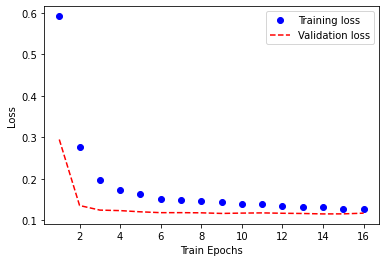

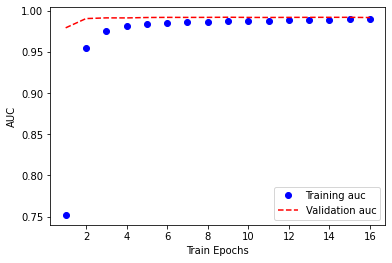

In [6]:
# inspect metrics
history_dict = history.history
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]
auc = history_dict["auc"]
val_auc = history_dict["val_auc"]
epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "r--", label="Validation loss")
plt.xlabel("Train Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(epochs, auc, "bo", label="Training auc")
plt.plot(epochs, val_auc, "r--", label="Validation auc")
plt.xlabel("Train Epochs")
plt.ylabel("AUC")
plt.legend()
plt.show()

In [7]:
n = 5
s = 100

p = model.predict(x_val[:1000,:])[:, 0]

scores = eg.get_scores(x_val[:1000,:])
ix_srt = np.argsort(scores)

probs = eg.get_probabilities(x_val[:1000,:])[1]

p = np.convolve(p[ix_srt[::-1]], np.ones(n)/n, mode='valid')
scores = np.convolve(scores[ix_srt[::-1]], np.ones(n)/n, mode='valid')
probs = np.convolve(probs[ix_srt[::-1]], np.ones(n)/n, mode='valid')

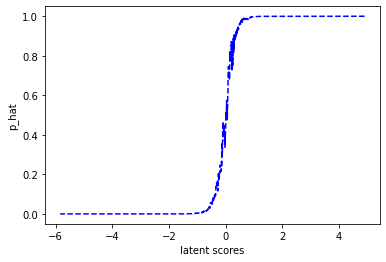

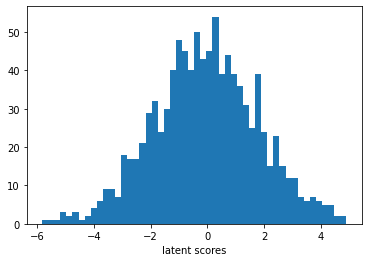

In [8]:
plt.plot(scores, p, '--b')
plt.xlabel('latent scores')
plt.ylabel('p_hat')
plt.show()

plt.hist(scores, bins=50)
plt.xlabel('latent scores')
plt.show()

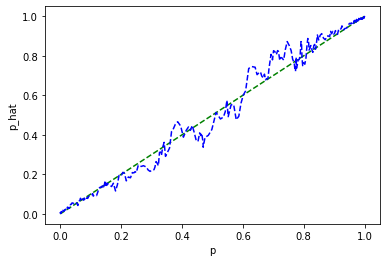

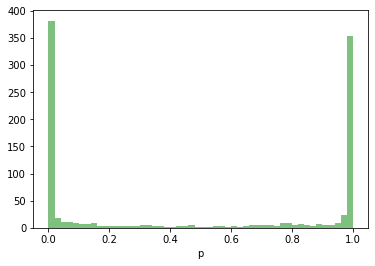

In [9]:
plt.plot(probs, probs, '--g')
plt.plot(probs, p, '--b')
plt.xlabel('p')
plt.ylabel('p_hat')
plt.show()

plt.hist(probs, bins=50, color='g', alpha=0.5)
plt.xlabel('p')
plt.show()

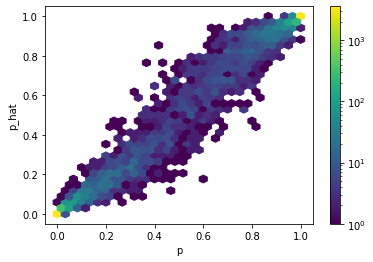

In [10]:
n = 1
s = 100

p = model.predict(x_val[:10000,:])[:, 0]

scores = eg.get_scores(x_val[:10000,:])

probs = eg.get_probabilities(x_val[:10000,:])[1]

plt.hexbin(probs, p, gridsize=30, bins='log')
plt.colorbar()
plt.xlabel('p')
plt.ylabel('p_hat')
plt.show()

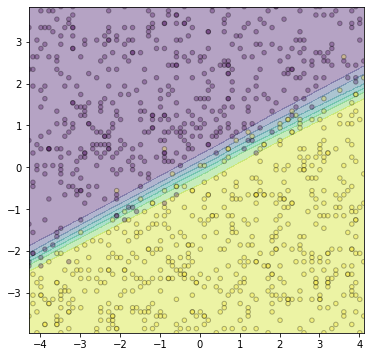

In [11]:
# Plot decision regions
I, J = 2, 6
x_min, x_max = x_val[:, I].min(), x_val[:, I].max()
y_min, y_max = x_val[:, J].min(), x_val[:, J].max()
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
xxyy = np.c_[xx.ravel(), yy.ravel()]
x_ = np.zeros((xxyy.shape[0], 10))
x_[:, I] = xxyy[:, 0]
x_[:, J] = xxyy[:, 1]
z = model.predict(x_)
z = z.reshape(xx.shape)
y_ = eg.get_labels(x_)

fig = plt.figure(figsize=(6,6))
ax = fig.gca()
ax.contourf(xx, yy, z, alpha=0.4)
ixs = np.random.randint(0, y_.shape[0]-1, 1000)
ax.scatter(x_[ixs, I], x_[ixs, J], c=y_[ixs], s=20, alpha=0.3, edgecolor="k")
plt.show()

#model.summary()

In [12]:
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_96 (Dense)            (None, 30)                330       
                                                                 
 dropout_72 (Dropout)        (None, 30)                0         
                                                                 
 dense_97 (Dense)            (None, 30)                930       
                                                                 
 dropout_73 (Dropout)        (None, 30)                0         
                                                                 
 dense_98 (Dense)            (None, 30)                930       
                                                                 
 dropout_74 (Dropout)        (None, 30)                0         
                                                                 
 dense_99 (Dense)            (None, 1)               

In [13]:
champion_params

{'learning_rate': 0.008,
 'batch': 8,
 'epoch': 10,
 'optimizer': 'sgd',
 'best_loss': {'loss': 0.11381775885820389, 'epoch': 16},
 'best_auc': {'auc': 0.9921242594718933, 'epoch': 16},
 'best_accuracy': {'accuracy': 0.9502999782562256, 'epoch': 16},
 'model': <keras.engine.sequential.Sequential at 0x7f152a166160>}

In [14]:
scan_results

[{'learning_rate': 2.4e-05,
  'batch': 256,
  'epoch': 280,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.12078937888145447, 'epoch': 394},
  'best_auc': {'auc': 0.9916186332702637, 'epoch': 394},
  'best_accuracy': {'accuracy': 0.9495999813079834, 'epoch': 393}},
 {'learning_rate': 3e-05,
  'batch': 256,
  'epoch': 280,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.11788459122180939, 'epoch': 394},
  'best_auc': {'auc': 0.9918152093887329, 'epoch': 394},
  'best_accuracy': {'accuracy': 0.9488499760627747, 'epoch': 391}},
 {'learning_rate': 3.6e-05,
  'batch': 256,
  'epoch': 280,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.11664150655269623, 'epoch': 394},
  'best_auc': {'auc': 0.9919565320014954, 'epoch': 391},
  'best_accuracy': {'accuracy': 0.949150025844574, 'epoch': 319}},
 {'learning_rate': 0.004,
  'batch': 256,
  'epoch': 590,
  'optimizer': 'sgd',
  'best_loss': {'loss': 0.11612804234027863, 'epoch': 788},
  'best_auc': {'auc': 0.9919256567955017, 'epoch': 787},

### Tuning notes: 

Data: train 100096 / val 20000

--
* model: 30, 0.25, 30, 0.25, 30, 0.25, 30, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 80/80 **val_loss: 0.4221** - val_accuracy: 0.7657 - val_auc: 0.9857

--
* model: 30, 0.25, 30, 0.25, 30, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 60/80 **val_loss: 0.3241** - val_accuracy: 0.8463 - val_auc: 0.9856

--
* model: 40, 0.25, 40, 0.25, 40, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 40/80 **val_loss: 0.2726** - val_accuracy: 0.8848 - val_auc: 0.9889

--
* model: 50, 0.25, 50, 0.25, 50, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 38/80 **val_loss: 0.2555** - val_accuracy: 0.8832 - val_auc: 0.9916

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 28/80 **val_loss: 0.2552** - val_accuracy: 0.8909 - val_auc: 0.9929

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / Nadam lr: 2e-5
* Epoch: 48/80 **0.2557** - val_accuracy: 0.8771 - val_auc: 0.9935

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 20, 0.25, 6, 0.25, 1/ batch: 256 / Nadam lr: 2e-5
* Epoch: 47/80 **0.3482** - val_accuracy: 0.8346 - val_auc: 0.9910

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / SGD lr: 5e-3
* Epoch: 59/80 **0.2176** - val_accuracy: 0.8953 - val_auc: 0.9961

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / SGD lr: 3e-3
* Epoch: 80/100 **0.2205** - val_accuracy: 0.8970 - val_auc: 0.9951

--
8/1e-2=> 0.2021 - val_accuracy: 0.9207 - val_auc: 0.9904
8/8e-3=> 0.26...
8/1.3e-2=> 0.25